In [1]:
from votekit.pref_profile import PreferenceProfile
from votekit.ballot import Ballot
from src.edouard.utils import convert_pf_to_numpy_arrays
import numpy as np
from src.edouard.permutations import (
    idx_to_perm, 
    perm_to_idx, 
    update_perm_idx, 
    update_perm_idx_vectorized,
    WeightVectorCalculator
)
from votekit.cvr_loaders import load_scottish

#3 winner election where two winners have initial quota; 
#they take >14 iterations of keep factors to get within tolerance of quota
#their final keep factor converges to 2/3+O(epsilon)

deg2_profile = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"B"}), frozenset({"C"})), weight=90),
            Ballot(ranking=(frozenset({"B"}), frozenset({"A"}), frozenset({"C"})), weight=90),
            Ballot(ranking=(frozenset({"A"}), frozenset({"C"})), weight=30),
            Ballot(ranking=(frozenset({"B"}), frozenset({"C"})), weight=30),
            Ballot(ranking=(frozenset({"C"}),), weight=61),
            Ballot(ranking=(frozenset({"D"}),), weight=99),
        ),
        candidates=("A", "B", "C", "D"),
    )

many_exhaust_profile = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"C"})), weight=120),
            Ballot(ranking=(frozenset({"B"}),), weight=102),
            Ballot(ranking=(frozenset({"C"}),), weight=77),
            Ballot(ranking=(frozenset({"D"}),), weight=60),
            Ballot(ranking=(frozenset({"E"}),), weight=51),
            Ballot(ranking=(frozenset({"F"}),), weight=40),
        ),
        candidates=("A", "B", "C", "D", "E", "F"),
    )

squeeze_profile = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"B"})), weight=60),
            Ballot(ranking=(frozenset({"A"}),), weight=90),
            Ballot(ranking=(frozenset({"B"}),), weight=63),
            Ballot(ranking=(frozenset({"C"}),), weight=87),
        ),
        candidates=("A", "B", "C"),
    )

fractional_not_same_as_meek_profile = PreferenceProfile(
        ballots=(
            Ballot(ranking=(frozenset({"A"}), frozenset({"B"})), weight=70),
            Ballot(ranking=(frozenset({"B"}),), weight=80),
            Ballot(ranking=(frozenset({"C"}),), weight=85),
            Ballot(ranking=(frozenset({"D"}), frozenset({"A"})), weight=35),
            Ballot(ranking=(frozenset({"E"}), frozenset({"A"})), weight=30),
        ),
        candidates=("A", "B", "C", "D", "E"),
    )

some_pf = load_scottish("data/scot-elex/5_cands/aberdeen_2022_ward11.csv")[0]

In [2]:
from src.edouard.MeekSTV import MeekSTV

elec = MeekSTV(
    profile=fractional_not_same_as_meek_profile,
    m=2)

#elec._play_by_play
print(elec._play_by_play[1]["keep_factors"])
print(elec._core.detailed_tally_per_deg(1))
elec._core.instant_keep_factors_from_round(0)

[]
({(): np.float64(300.0)}, {(): 0})


In [4]:
from src.edouard.MeekSTV import MeekCore

ballot_matrix, mult_vec, fpv_vec = convert_pf_to_numpy_arrays(
    fractional_not_same_as_meek_profile
)

core = MeekCore(
    ballot_matrix=ballot_matrix,
    mult_vec=mult_vec,
    m=2,
    num_cands=5,
    winner_to_cand=[0],
    initial_losers=[3,4],)

core._run_first_round()

[0] [0.69117648]


(array([ 93.30882519, 101.6176462 ,  85.        ,   0.        ,
          0.        ]),
 {'fpv_vec': array([   1,    1,    2, -126, -126], dtype=int8),
  'winner_combination_vec': array([1., 0., 0., 1., 1.]),
  'winner_to_cand': [0, 1]},
 {'round_number': -1,
  'new_winners_or_losers': [1],
  'keep_factors': array([0.69117648, 1.        ]),
  'quota': np.float64(93.30882479646097),
  'iterations': 1,
  'round_type': 'winner'},
 None)

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src.edouard.MeekSTV import MeekCore
import string

class MeekGraph:
    def __init__(self, profile, m, auditable_margins_per_deg, use_numerical_labels=False):
        self.profile = profile
        self.ballot_matrix, self.mult_vec, self.fpv_vec = convert_pf_to_numpy_arrays(profile)
        self.m = m
        self.num_cands = len(profile.candidates)
        self.auditable_margins_per_deg = auditable_margins_per_deg
        self.candidates = list(profile.candidates)
        self.use_numerical_labels = use_numerical_labels
        
        # Initialize NetworkX graph
        self.tree = nx.DiGraph()
        
        # Keep track of nodes by layer and their coordinates
        self.nodes_by_layer = {}
        self.node_positions = {}
        self.node_counter = 0
        
        # Node ID mapping: node_id -> node_data
        self.node_lookup = {}
        
        # Build the tree
        self.build_tree()
    
    def node_to_string(self, node):
        """Convert a node dict to a unique string identifier"""
        winners = sorted(node["winner_to_cand"])
        losers = sorted(node["initial_losers"])
        return f"W:{','.join(map(str, winners))}_L:{','.join(map(str, losers))}"
    
    def get_node_id(self, layer, position_in_layer):
        """Generate node ID in format NX (e.g., 0A, 1B, 2C, etc.)"""
        if position_in_layer < 26:
            letter = string.ascii_uppercase[position_in_layer]
        else:
            # Handle more than 26 nodes per layer (unlikely but safe)
            letter = f"Z{position_in_layer - 25}"
        return f"{layer}{letter}"
    
    def string_to_readable(self, node_str):
        """Convert node string to human-readable format using candidate names"""
        if node_str == "W:_L:":
            return "Root"
        
        parts = node_str.split('_')
        winners_part = parts[0][2:]  # Remove 'W:'
        losers_part = parts[1][2:]   # Remove 'L:'
        
        winner_names = [self.candidates[int(i)] for i in winners_part.split(',') if i]
        loser_names = [self.candidates[int(i)] for i in losers_part.split(',') if i]
        
        result = ""
        if winner_names:
            result += f"W:{','.join(winner_names)}"
        if loser_names:
            if result:
                result += " "
            result += f"L:{','.join(loser_names)}"
        
        return result if result else "Root"
    
    def add_node_to_graph(self, node, layer):
        """Add a node to the graph with proper positioning"""
        node_str = self.node_to_string(node)
        
        if node_str not in self.tree:
            # Add to layer tracking
            if layer not in self.nodes_by_layer:
                self.nodes_by_layer[layer] = []
            
            # Calculate position
            position_in_layer = len(self.nodes_by_layer.get(layer, []))
            node_id = self.get_node_id(layer, position_in_layer)
            x_position = position_in_layer
            y_position = -layer  # Negative so root is at top
            
            self.nodes_by_layer[layer].append(node_str)
            self.node_positions[node_str] = (x_position, y_position)
            
            # Store node lookup information
            self.node_lookup[node_id] = {
                'node_str': node_str,
                'winner_to_cand': node["winner_to_cand"].copy(),
                'initial_losers': node["initial_losers"].copy(),
                'layer': layer,
                'position_in_layer': position_in_layer
            }
            
            # Add to NetworkX graph with attributes
            self.tree.add_node(node_str, 
                             layer=layer,
                             winners=node["winner_to_cand"].copy(),
                             losers=node["initial_losers"].copy(),
                             readable=self.string_to_readable(node_str),
                             node_id=node_id)
        
        return node_str

    def get_edge_label(self, from_node, to_node, use_numerical=False):
        """Generate edge label describing the transition"""
        from_winners = set(from_node["winner_to_cand"])
        to_winners = set(to_node["winner_to_cand"])
        from_losers = set(from_node["initial_losers"])
        to_losers = set(to_node["initial_losers"])
        
        new_winners = to_winners - from_winners
        new_losers = to_losers - from_losers
        
        if new_winners:
            candidate_idx = list(new_winners)[0]
            if use_numerical:
                return f"Elect {candidate_idx}"
            else:
                candidate_name = self.candidates[candidate_idx]
                # Add line break for long names (>8 characters)
                if len(candidate_name) > 8:
                    return f"Elect\n{candidate_name}"
                else:
                    return f"Elect {candidate_name}"
        elif new_losers:
            candidate_idx = list(new_losers)[0]
            if use_numerical:
                return f"Eliminate {candidate_idx}"
            else:
                candidate_name = self.candidates[candidate_idx]
                # Add line break for long names (>8 characters)
                if len(candidate_name) > 8:
                    return f"Eliminate\n{candidate_name}"
                else:
                    return f"Eliminate {candidate_name}"
        else:
            return ""

    def next_possible_nodes(self, node):
        """Find next possible nodes and add them to the graph"""
        # Check if we already have enough winners - stop if we do
        if len(node["winner_to_cand"]) >= self.m:
            return []  # Stop expanding this branch
            
        try:
            current_core = MeekCore(
                ballot_matrix=self.ballot_matrix,
                mult_vec=self.mult_vec,
                m=self.m,
                num_cands=self.num_cands,
                winner_to_cand=node["winner_to_cand"],
                initial_losers=node["initial_losers"],
            )
            tallies, helper_vecs, play, tiebreak = current_core._run_first_round()
        except Exception as e:
            print(f"Error processing node {self.string_to_readable(self.node_to_string(node))}: {e}")
            return []
            
        deg = len(node["winner_to_cand"])
        auditable_margin = self.auditable_margins_per_deg[deg]
        quota = play["quota"]

        current_node_str = self.node_to_string(node)
        current_layer = len(node["winner_to_cand"]) + len(node["initial_losers"])
        possible_nodes = []

        tallies_with_masked_winners = tallies.copy()
        tallies_with_masked_winners[node["winner_to_cand"]] = -1

        # Check for mandatory winners (tallies significantly above quota)
        if np.any(tallies_with_masked_winners > quota + auditable_margin):
            only_possible_winner = np.argmax(tallies_with_masked_winners)
            only_possible_node = {
                "winner_to_cand": node["winner_to_cand"] + [only_possible_winner],
                "initial_losers": node["initial_losers"],
            }
            possible_nodes = [only_possible_node]
        else:
            # Check for possible winners (tallies close to quota)
            if np.any(tallies_with_masked_winners > quota - auditable_margin):
                possible_winner_mask = tallies_with_masked_winners > quota - auditable_margin
                biggest_tally = np.argmax(tallies_with_masked_winners)
                within_margin_of_biggest_mask = np.where(
                    possible_winner_mask & (tallies_with_masked_winners >= tallies_with_masked_winners[biggest_tally] - auditable_margin)
                )[0]
                
                for possible_winner in within_margin_of_biggest_mask:
                    possible_node = {
                        "winner_to_cand": node["winner_to_cand"] + [possible_winner],
                        "initial_losers": node["initial_losers"],
                    }
                    possible_nodes.append(possible_node)
            
            # Check for possible losers (tallies close to minimum)
            # Only consider candidates not already winners or losers
            active_candidates = set(range(self.num_cands)) - set(node["winner_to_cand"]) - set(node["initial_losers"])
            if active_candidates:
                active_tallies = tallies[list(active_candidates)]
                if len(active_tallies) > 0:
                    lowest_tally = np.min(active_tallies)
                    within_margin_of_lowest_mask = np.where(tallies <= lowest_tally + auditable_margin)[0]
                    
                    for possible_loser in within_margin_of_lowest_mask:
                        if possible_loser in active_candidates:
                            possible_node = {
                                "winner_to_cand": node["winner_to_cand"],
                                "initial_losers": node["initial_losers"] + [possible_loser],
                            }
                            possible_nodes.append(possible_node)

        # Add nodes to graph and create edges with labels
        for possible_node in possible_nodes:
            next_node_str = self.add_node_to_graph(possible_node, current_layer + 1)
            edge_label = self.get_edge_label(node, possible_node, use_numerical=self.use_numerical_labels)
            self.tree.add_edge(current_node_str, next_node_str, label=edge_label)

        return possible_nodes

    def build_tree(self):
        """Build the complete tree layer by layer"""
        # Start with root node
        root_node = {"winner_to_cand": [], "initial_losers": []}
        root_node_str = self.add_node_to_graph(root_node, 0)
        
        # Build tree layer by layer
        current_layer_nodes = [root_node]
        
        # Continue until we've explored all possibilities or reached max winners
        max_iterations = self.num_cands  # Safety limit
        for layer in range(max_iterations):
            next_layer_nodes = []
            
            for node in current_layer_nodes:
                possible_nodes = self.next_possible_nodes(node)
                next_layer_nodes.extend(possible_nodes)
            
            # Remove duplicates for next iteration
            seen = set()
            unique_next_nodes = []
            for node in next_layer_nodes:
                node_str = self.node_to_string(node)
                if node_str not in seen:
                    seen.add(node_str)
                    unique_next_nodes.append(node)
            
            current_layer_nodes = unique_next_nodes
            
            if not current_layer_nodes:
                break
    
    def lookup_node(self, node_id):
        """Look up a node by its ID (e.g., '0A', '1B', etc.)"""
        if node_id in self.node_lookup:
            info = self.node_lookup[node_id]
            winners = [self.candidates[i] for i in info['winner_to_cand']]
            losers = [self.candidates[i] for i in info['initial_losers']]
            
            return {
                'node_id': node_id,
                'layer': info['layer'],
                'position_in_layer': info['position_in_layer'],
                'winner_to_cand': info['winner_to_cand'],
                'initial_losers': info['initial_losers'],
                'winners': winners,
                'losers': losers
            }
        else:
            available_ids = sorted(self.node_lookup.keys())
            raise ValueError(f"Node ID '{node_id}' not found. Available IDs: {available_ids}")
    
    def list_nodes(self):
        """List all node IDs in the tree"""
        return sorted(self.node_lookup.keys())
    
    def plot_tree(self, figsize=(15, 10), node_size=3000, font_size=8, label_nodes=False, 
                  label_edges=True, title=None, spacing_multiplier=3.0):
        """Plot the tree with layers arranged vertically"""
        if not self.tree.nodes():
            print("No nodes to plot")
            return
            
        plt.figure(figsize=figsize)
        
        # Calculate dynamic spacing based on tree complexity
        max_layer_width = max(len(nodes) for nodes in self.nodes_by_layer.values()) if self.nodes_by_layer else 1
        num_layers = len(self.nodes_by_layer)
        
        # Increase spacing for complex trees
        horizontal_spacing = spacing_multiplier * max(2.0, max_layer_width / 3)
        vertical_spacing = spacing_multiplier * 1.5
        
        # Adjust positions to center each layer with better spacing
        adjusted_positions = {}
        for layer, nodes in self.nodes_by_layer.items():
            layer_width = len(nodes)
            for i, node_str in enumerate(nodes):
                x_offset = (i - (layer_width - 1) / 2) * horizontal_spacing
                y_position = -layer * vertical_spacing
                adjusted_positions[node_str] = (x_offset, y_position)
        
        # Create labels - either node IDs or readable names
        labels = None
        if label_nodes:
            labels = {node_str: self.tree.nodes[node_str]['node_id'] for node_str in self.tree.nodes()}
        
        # Draw the graph
        nx.draw(self.tree, 
               pos=adjusted_positions,
               labels=labels,
               with_labels=label_nodes,
               node_color='lightblue',
               node_size=node_size,
               font_size=font_size,
               font_weight='bold',
               arrows=True,
               arrowsize=20,
               edge_color='gray',
               arrowstyle='->')
        
        # Add edge labels if requested
        if label_edges:
            edge_labels = nx.get_edge_attributes(self.tree, 'label')
            nx.draw_networkx_edge_labels(self.tree, 
                                       pos=adjusted_positions, 
                                       edge_labels=edge_labels,
                                       font_size=max(6, font_size-2))  # Smaller font for edge labels
        
        # Use custom title if provided, otherwise default
        if title is None:
            title = f"Meek STV Decision Tree\nElection: {self.m} winners from {self.num_cands} candidates"
        
        plt.title(title)
        plt.axis('equal')
        
        plt.tight_layout()
        plt.show()
    
    def get_stats(self):
        """Get statistics about the constructed tree"""
        stats = {
            'total_nodes': len(self.tree.nodes()),
            'total_edges': len(self.tree.edges()),
            'layers': len(self.nodes_by_layer),
            'nodes_per_layer': {layer: len(nodes) for layer, nodes in self.nodes_by_layer.items()}
        }
        return stats
    
    def analyze_paths(self):
        """Analyze all possible paths from root to leaves"""
        root = self.node_to_string({"winner_to_cand": [], "initial_losers": []})
        
        # Find all leaf nodes (nodes with no outgoing edges)
        leaves = [node for node in self.tree.nodes() if self.tree.out_degree(node) == 0]
        
        paths = []
        for leaf in leaves:
            try:
                path = nx.shortest_path(self.tree, root, leaf)
                paths.append(path)
            except nx.NetworkXNoPath:
                continue
        
        return paths
    
    def print_analysis(self):
        """Print detailed analysis of the tree"""
        stats = self.get_stats()
        print("Graph Statistics:")
        for key, value in stats.items():
            print(f"  {key}: {value}")
        
        print(f"\nCandidates: {self.candidates}")
        print(f"Target winners (m): {self.m}")
        print(f"Available node IDs: {self.list_nodes()}")
        
        paths = self.analyze_paths()
        print(f"\nTotal possible election paths: {len(paths)}")
        
        # Check if we have complete elections (paths reaching m winners)
        complete_elections = []
        for path in paths:
            leaf_node_str = path[-1]
            leaf_node = self.tree.nodes[leaf_node_str]
            if len(leaf_node['winners']) == self.m:
                complete_elections.append(path)
        
        print(f"Complete elections (with {self.m} winners): {len(complete_elections)}")
        
        if paths:
            print("\nSample paths (by Node ID):")
            for i, path in enumerate(paths[:3]):  # Show first 3 paths
                node_ids = [self.tree.nodes[node]['node_id'] for node in path]
                print(f"  Path {i+1}: {' → '.join(node_ids)}")
            
            if len(paths) > 3:
                print(f"  ... and {len(paths) - 3} more paths")

In [83]:
# Test with 2 winners to see if graph continues past first winner
test_graph = MeekGraph(deg2_profile, m=2, auditable_margins_per_deg=[0.01, 0.01, 0.01, 0.01])
print("Tree construction completed!")
test_graph.print_analysis()

[] []
[] []
[np.int64(0)] [0.93636365]
Tree construction completed!
Graph Statistics:
  total_nodes: 4
  total_edges: 3
  layers: 4
  nodes_per_layer: {0: 1, 1: 1, 2: 1, 3: 1}

Candidates: ['A', 'B', 'C', 'D']
Target winners (m): 2
Available node IDs: ['0A', '1A', '2A', '3A']

Total possible election paths: 1
Complete elections (with 2 winners): 1

Sample paths (by Node ID):
  Path 1: 0A → 1A → 2A → 3A


/tmp/ipykernel_1562433/711923744.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


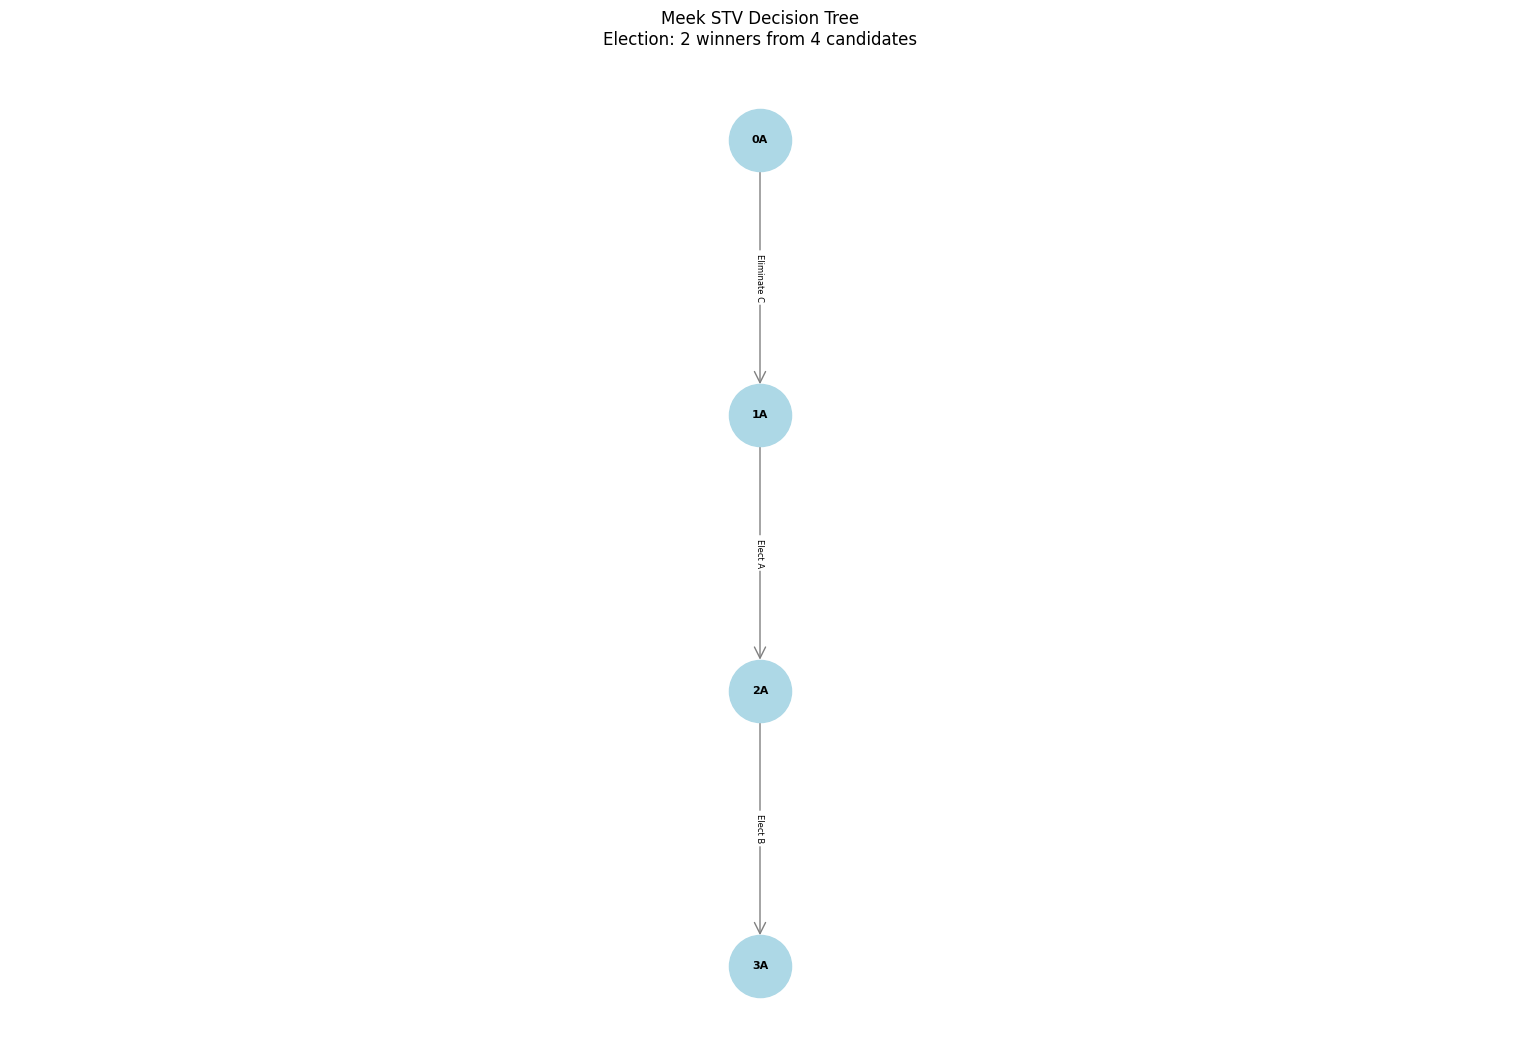

In [84]:
# Visualize the tree with new node IDs and custom node size
test_graph.plot_tree(label_nodes=True, label_edges=True, node_size=2000)

In [4]:
from votekit.cvr_loaders import load_scottish
from votekit.elections import FastSTV
#from src.edouard.MeekSTV import MeekSTV

some_pf = load_scottish("data/scot-elex/5_cands/aberdeen_2022_ward11.csv")[0]

meek_elec = MeekSTV(
    profile=some_pf,
    m=2)

frac_elec = FastSTV(
    profile=some_pf,
    m=2)

#print("Meek elected:", meek_elec.get_elected())
#print("Fractional elected:", frac_elec.get_elected())
#meek_elec.get_elected() == frac_elec.get_elected()

# repeat this over all files in data/scot-elex/5_cands/ and compare results
import os 
data_dir = "data/scot-elex/6_cands/"
files_scanned = 0
discrepant_idx = []
for filename in os.listdir(data_dir):
    files_scanned += 1
    if filename.endswith(".csv"):
        pf = load_scottish(os.path.join(data_dir, filename))[0]
        meek_elec = MeekSTV(
            profile=pf,
            m=3)
        frac_elec = FastSTV(
            profile=pf,
            m=3)
        meek_winners = meek_elec.get_elected()
        frac_winners = frac_elec.get_elected()
        if set(meek_winners) != set(frac_winners):
            discrepant_idx.append(files_scanned-1)
            print(f"Discrepancy in file {filename}:")
            print("Meek elected:", meek_winners)
            print("Fractional elected:", frac_winners)

print(f"Files scanned: {files_scanned}")
print(f"Discrepancies found: {len(discrepant_idx)}")

for idx in discrepant_idx:
    #check if in that election, the first winner was elected with a small margin above quota
    pf = load_scottish(os.path.join(data_dir, os.listdir(data_dir)[idx]))[0]
    frac_elec = FastSTV(
        profile=pf,
        m=3)
    quota = frac_elec.threshold
    for play in frac_elec._play_by_play:
        if play[-1] == 'election':
            w = play[1][0]
            print(frac_elec._fpv_by_round[play[0]])
            winner_margin = frac_elec._fpv_by_round[play[0]][w] - frac_elec.threshold
            num_votes = sum(frac_elec._wt_vec)
            if winner_margin/num_votes < .02:
                print(f"Winner {frac_elec.candidates[w]} margin above quota: {winner_margin}")
            #break
    


Discrepancy in file east_ayrshire_2022_ward7.csv:
Meek elected: ['Claire Leitch', 'Linda Holland', 'William Lennox']
Fractional elected: ['Claire Leitch', 'Linda Holland', 'Alyson Simmons']
Discrepancy in file dumgal_2012_ward8.csv:
Meek elected: ['Jim Dempster', 'Gill Dykes', 'John Syme']
Fractional elected: ['Jim Dempster', 'Gill Dykes', 'Andrew Wood']
Discrepancy in file south_lanarkshire_2012_ward10.csv:
Meek elected: ['John Cairney', 'Graham Scott', 'Jim Wardhaugh']
Fractional elected: ['John Cairney', 'Jim Wardhaugh', 'Gladys Miller']
Discrepancy in file angus_2022_ward7.csv:
Meek elected: ['Brenda Durno', 'Lois Speed', 'Graham Smith']
Fractional elected: ['Lois Speed', 'Brenda Durno', 'Derek Wann']
Discrepancy in file aberdeenshire_2022_ward15.csv:
Meek elected: ['Sarah Brown', 'Geva Blackett', 'Peter John Argyle']
Fractional elected: ['Sarah Brown', 'Geva Blackett', 'Anouk Kloppert']
Discrepancy in file perth_kinross_2012_ward9.csv:
Meek elected: ['Alan Livingstone', 'Henry And

In [89]:
patho_pf = load_scottish("data/scot-elex/6_cands/perth_kinross_2012_ward9.csv")[0]
frac_elec = FastSTV(    
    profile=patho_pf,
    m=3
)

print(patho_pf.candidates)
print("Quota:", frac_elec.threshold)
print(frac_elec.get_status_df())

meek_elec = MeekSTV(
    profile=patho_pf,
    m=3)

for play in meek_elec._play_by_play:
    print(play)

for play in frac_elec._play_by_play:
    if play[-1] == 'election':
        w = play[1][0]
        print(frac_elec._fpv_by_round[play[0]])
        winner_margin = frac_elec._fpv_by_round[play[0]][w] - frac_elec.threshold
        print(f"Winner {frac_elec.candidates[w]} margin above quota: {winner_margin}")

('Henry Anderson', 'Andrew Dundas', 'George Hayton', 'Alan Jack', 'Alan Livingstone', 'Wilma Lumsden')
Quota: 923
                      Status  Round
Alan Livingstone     Elected      1
Henry Anderson       Elected      3
Alan Jack            Elected      6
Wilma Lumsden     Eliminated      5
Andrew Dundas     Eliminated      4
George Hayton     Eliminated      2
{'round_number': 0, 'new_winners_or_losers': [4], 'keep_factors': array([1.]), 'quota': np.float64(922.250001), 'iterations': 1, 'round_type': 'winner'}
{'round_number': 1, 'new_winners_or_losers': [2], 'keep_factors': array([0.81300813]), 'quota': np.float64(904.0650418084715), 'iterations': 9, 'round_type': 'loser'}
{'round_number': 2, 'new_winners_or_losers': [0], 'keep_factors': array([0.75715649, 1.        ]), 'quota': np.float64(885.1159363190025), 'iterations': 9, 'round_type': 'winner'}
{'round_number': 3, 'new_winners_or_losers': [1], 'keep_factors': array([0.75575544, 0.95438804]), 'quota': np.float64(884.13306403479

In [90]:

patho_bal_matrix, patho_mult_vec, patho_fpv_vec = convert_pf_to_numpy_arrays(patho_pf)
#change all -126 to -127 including last column
patho_bal_matrix[patho_bal_matrix == -126] = -127
patho_pf.candidates

('Henry Anderson',
 'Andrew Dundas',
 'George Hayton',
 'Alan Jack',
 'Alan Livingstone',
 'Wilma Lumsden')

In [93]:
# see if any rows of the ballot matrix are [5,0, -127, ...]
searching_for_row = np.array([3,0] + [-127]*(patho_bal_matrix.shape[1]-3)+[-127])
searching_for_row2 = np.array([0,3] + [-127]*(patho_bal_matrix.shape[1]-3)+[-127])
for i in range(patho_bal_matrix.shape[0]):
    if np.array_equal(patho_bal_matrix[i,:], searching_for_row):
        print(patho_bal_matrix[i,:2])
        print(f"Found matching row1 at index {i} with weight {modified_mult_vec[i]}")
    if np.array_equal(patho_bal_matrix[i,:], searching_for_row2):
        print(patho_bal_matrix[i,:2])
        print(f"Found matching row2 at index {i} with weight {modified_mult_vec[i]}")

[0 3]
Found matching row2 at index 37 with weight 16.0
[3 0]
Found matching row1 at index 304 with weight 13.0


In [94]:
modified_mult_vec = np.copy(patho_mult_vec)
modified_mult_vec[37] = 15
modified_mult_vec[304] = 14

In [98]:
#from src.edouard.FastSTV import FastCore

modified_elect = FastCore(
    ballot_matrix = patho_bal_matrix,
    mult_vec = modified_mult_vec,
    num_cands = len(patho_pf.candidates),
    candidates = list(patho_pf.candidates),
    m = 3,
)


for play in modified_elect._play_by_play:
    if play[-1] == 'election':
        w = play[1][0]
        print(modified_elect._fpv_by_round[play[0]])
        winner_margin = modified_elect._fpv_by_round[play[0]][w] - modified_elect.threshold
        print(f"Winner {modified_elect.candidates[w]} margin above quota: {winner_margin}")

print(modified_elect.threshold)
for fpv in modified_elect._fpv_by_round:
    print(fpv)


[ 891.  369.  244.  445. 1112.  628.]
Winner Alan Livingstone margin above quota: 189.0
[997.2176259    0.           0.         759.0647482    0.
 720.80665468]
Winner Henry Anderson margin above quota: 74.2176258992813
[  0.           0.           0.           0.           0.
 960.31579436]
Winner Wilma Lumsden margin above quota: 37.31579435857748
923
[ 891.  369.  244.  445. 1112.  628.]
[899.66816547 381.23741007 284.28147482 494.28956835   0.
 640.4073741 ]
[922.36780576 450.69604317   0.         597.92625899   0.
 670.95683453]
[997.2176259    0.           0.         759.0647482    0.
 720.80665468]
[  0.           0.           0.         767.90040614   0.
 776.60724524]
[  0.           0.           0.           0.           0.
 960.31579436]
[0 0 0 0 0 0]


In [101]:
meek_patho = MeekSTV(
    profile=patho_pf,
    m=3)

for fpv, play in zip(meek_patho._fpv_by_round, meek_patho._play_by_play):
    print(fpv)
    print(play['quota'])

[ 892.  369.  244.  444. 1112.  628.]
922.250001
[901.53658528 382.46341452 288.31707279 498.22764181 904.06504246
 641.65040639]
904.0650418084715
[926.29914111 446.59828223   0.         608.10877794 885.11593709
 674.3416029 ]
885.1159363190025
[884.13306435 450.15914011   0.         612.86795327 884.13306429
 705.23903012]
884.1330640347968
[833.50488744   0.           0.         810.0735163  833.50488738
 856.9362528 ]
833.5048869818722


In [1]:
from src.edouard.permutations import update_perm_idx_vectorized, WeightVectorCalculator

from typing import Optional, Callable, Union, List
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from itertools import groupby
from src.edouard.utils import convert_pf_to_numpy_arrays

class MeekSTV:

    def __init__(
        self,
        profile,
        m: int = 1,
        tiebreak: Optional[str] = None,
    ):
        self.profile = profile
        self.m = m

        #self._ballot_length = profile.max_ranking_length
        #self._winner_tiebreak = tiebreak
        #self._loser_tiebreak = tiebreak if tiebreak is not None else "first_place"

        self.candidates = list(profile.candidates)

        self._ballot_matrix, self._mult_vec, self._fpv_vec = convert_pf_to_numpy_arrays(profile)

        self._core = MeekCore(
            ballot_matrix=self._ballot_matrix,
            mult_vec=self._mult_vec.copy(),
            num_cands=len(self.candidates),
            m=m)

        self._fpv_by_round, self._play_by_play, self._tiebreak_record, self._winner_to_cand = self._core._run_core()

    def get_elected(self) -> List:
        return [self.candidates[i] for i in self._winner_to_cand]
    
class MeekCore:
    def __init__(
        self,
        ballot_matrix: NDArray,
        mult_vec: NDArray,
        num_cands: int,
        m: int = 1,
        pos_vec: NDArray = None,
        fpv_vec: NDArray = None,
        winner_combination_vec: NDArray = None,
        bool_ballot_matrix: NDArray = None,
        winner_to_cand: List = [],
        initial_losers: List = [],
        tiebreak: Optional[str] = None,
        tolerance: float = 1e-6,
        epsilon: float = 1e-6,
        max_iterations: int = 500,
    ):
        """
        The play-by-play logs some information for the public methods:
                    - round number
                    - list of candidates elected or eliminated this round
                    - keep factors of all winners in this round
                    - quota this round (after calibration)
                    - number of iterations used to calibrate keep factors & quota
                    - round type: 'election' or 'elimination'
        """
        self._ballot_matrix = ballot_matrix
        self._mult_vec = mult_vec
        self._num_cands = num_cands
        self.m = m
        self.tolerance = tolerance
        self.epsilon = epsilon
        self._max_iterations = max_iterations

        self._winner_tiebreak = tiebreak
        self._loser_tiebreak = tiebreak if tiebreak is not None else "first_place"

        self._initial_pos_vec, self._initial_fpv_vec, self._initial_winner_comb_vec, self._initial_bool_ballot_matrix = self.update_helpers(
            pos_vec,
            fpv_vec,
            winner_combination_vec,
            bool_ballot_matrix,
            winner_to_cand,
            new_losers=initial_losers,
        )
        self._initial_winner_to_cand = winner_to_cand

        self._wt_calculator = WeightVectorCalculator(self.m-1, self.m)

        self._fpv_by_round, self._play_by_play, self._tiebreak_record, self._winner_to_cand = self._run_core()
        #self.election_states = self._make_election_states()

    def update_helpers(self,
                   pos_vec = None,
                   fpv_vec = None,
                   winner_comb_vec = None,
                   bool_ballot_matrix = None,
                   winner_to_cand = [],
                   new_losers = []):
        num_ballots = self._ballot_matrix.shape[0]
        cand_to_winner = np.zeros(self._num_cands, dtype=np.int8) -1
        for idx, cand in enumerate(winner_to_cand):
            cand_to_winner[cand] = idx
        if pos_vec is None:
            pos_vec = np.zeros(num_ballots, dtype=np.int8)
        #assert len(pos_vec) == num_ballots 
        if fpv_vec is None:
            fpv_vec = self._ballot_matrix[np.arange(self._ballot_matrix.shape[0]), pos_vec]
        if winner_comb_vec is None:
            winner_comb_vec = np.zeros(num_ballots)
        if bool_ballot_matrix is None:
            bool_ballot_matrix = self._ballot_matrix != -127
        if len(new_losers)>0:
            bool_ballot_matrix &= ~np.isin(self._ballot_matrix, new_losers)
            needs_update = np.isin(fpv_vec, new_losers)
            pos_vec[needs_update] = np.argmax(bool_ballot_matrix[needs_update, :], axis = 1)
            fpv_vec[needs_update] = self._ballot_matrix[needs_update, pos_vec[needs_update]]
        for _ in range(len(winner_to_cand)):
            needs_update = np.isin(fpv_vec, winner_to_cand)
            winner_comb_vec[needs_update] = update_perm_idx_vectorized(winner_comb_vec[needs_update], cand_to_winner[fpv_vec[needs_update]], self.m)
            bool_ballot_matrix[needs_update, pos_vec[needs_update]] = False
            pos_vec[needs_update] = np.argmax(bool_ballot_matrix[needs_update,:], axis = 1)
            fpv_vec[needs_update] = self._ballot_matrix[needs_update, pos_vec[needs_update]]
        return pos_vec, fpv_vec, winner_comb_vec, bool_ballot_matrix
    
    def tally_calculator_engine(self, fpv_vec, winner_combination_vec, keep_factors, winner_to_cand):
        unique_winner_combos = np.unique(winner_combination_vec)
        overall_tallies = np.zeros(self._num_cands)
        for perm_idx in unique_winner_combos:
            ballot_mask = winner_combination_vec == perm_idx
            non_exhausted_mask = ballot_mask & (fpv_vec >=0)

            wt_vec_for_this_permutation = self._wt_calculator.make_wt_vec(perm_idx, keep_factors)
            weights_per_winner=sum(self._mult_vec[ballot_mask])*wt_vec_for_this_permutation[:-1]

            leftover_weight = wt_vec_for_this_permutation[-1]
            leftover_tally =np.bincount(fpv_vec[non_exhausted_mask], weights=self._mult_vec[non_exhausted_mask]*leftover_weight, minlength=self._num_cands)
            leftover_tally = leftover_tally.astype(np.float64)
            leftover_tally[winner_to_cand] += weights_per_winner[:len(winner_to_cand)]
            overall_tallies += leftover_tally
        return overall_tallies

    def calibrate_keep_factors(self, fpv_vec, winner_combination_vec, winner_to_cand, keep_factors):
        for iteration in range(self._max_iterations):
            tallies = self.tally_calculator_engine(fpv_vec, winner_combination_vec, keep_factors, winner_to_cand)
            quota = sum(tallies) / (self.m+1) + self.epsilon
            if np.any(tallies[winner_to_cand] < quota):
                print(f"tallies: {tallies}, winner_combination_vec: {winner_combination_vec}, m: {self.m}")
                raise ValueError(f"Tally for a winning candidate is below quota: {tallies[winner_to_cand]} < {quota}, keep factors: {keep_factors}")
            if np.all(tallies[winner_to_cand] - quota < self.tolerance):
                break
            new_keep_factors = quota/tallies[winner_to_cand]
            keep_factors *= new_keep_factors
        return tallies, keep_factors, iteration+1, quota
    
    def meek_stv_engine(self, 
                        pos_vec,
                        fpv_vec, 
                        winner_combination_vec,
                        bool_ballot_matrix,
                        winner_to_cand,
                        hopeful,
                        keep_factors):
        #1) calibrate keep factors
        #2) record info and determine loser/winner(s)
        #3) update helpers
        tallies, keep_factors, iterations, current_quota = self.calibrate_keep_factors(
            fpv_vec, 
            winner_combination_vec,
            winner_to_cand,
            keep_factors=keep_factors
        )
        non_winner_tallies = np.copy(tallies)
        non_winner_tallies[winner_to_cand] = -1
        if np.any(non_winner_tallies > current_quota):
            new_winners = np.where(non_winner_tallies > current_quota)[0].tolist()
            #print(f"New winners: {new_winners} elected with tallies {tallies[new_winners]} above quota {current_quota}")
            winner_to_cand.extend(new_winners)
            keep_factors = np.append(keep_factors, np.ones(len(new_winners), dtype=np.float64))
            round_type = "winner"
            new_losers = []
        else:
            hopeful_tallies = tallies[hopeful]
            new_loser = int(hopeful[int(np.argmin(hopeful_tallies))])
            hopeful.remove(new_loser)
            round_type = "loser"
            new_losers = [new_loser]
            #print("New loser:", new_loser)
            new_winners = []
        if len(winner_to_cand) < self.m:
            pos_vec, fpv_vec, winner_combination_vec, bool_ballot_matrix = self.update_helpers(
                pos_vec=pos_vec,
                fpv_vec=fpv_vec,
                winner_comb_vec=winner_combination_vec,
                bool_ballot_matrix=bool_ballot_matrix,
                winner_to_cand=winner_to_cand,
                new_losers=new_losers
            )
        return (tallies, keep_factors, iterations, current_quota, 
                pos_vec, fpv_vec, winner_combination_vec, 
                bool_ballot_matrix, round_type, new_losers, new_winners, winner_to_cand, hopeful)
    
    def _run_core(self):
        fpv_by_round = []
        play_by_play = []
        tiebreak_record = []

        pos_vec = self._initial_pos_vec.copy()
        fpv_vec = self._initial_fpv_vec.copy()
        winner_combination_vec = self._initial_winner_comb_vec.copy()
        bool_ballot_matrix = self._initial_bool_ballot_matrix.copy()
        winner_to_cand = self._initial_winner_to_cand.copy()
        keep_factors = np.array([], dtype=np.float64)

        hopeful = np.arange(0, self._num_cands).tolist()

        round_number = 0
        while len(winner_to_cand) < self.m:
            (
                tallies,
                keep_factors,
                iterations,
                current_quota,
                pos_vec,
                fpv_vec,
                winner_combination_vec,
                bool_ballot_matrix,
                round_type,
                new_losers,
                new_winners,
                winner_to_cand,
                hopeful,
            ) = self.meek_stv_engine(
                pos_vec,
                fpv_vec,
                winner_combination_vec,
                bool_ballot_matrix,
                winner_to_cand,
                hopeful,
                keep_factors,
            )
            fpv_by_round.append(tallies.copy())
            winners_or_losers = new_losers if round_type == "loser" else new_winners
            #tiebreak_record.append #TODO: tiebreaks
            play_by_play.append(
                {
                    "round_number": round_number,
                    "new_winners_or_losers": winners_or_losers,
                    "keep_factors": keep_factors.copy(),
                    "quota": current_quota,
                    "iterations": iterations,
                    "round_type": round_type,
                }
            )
            round_number += 1

        return fpv_by_round, play_by_play, tiebreak_record, winner_to_cand

In [21]:
from votekit.pref_profile import RankProfile, ProfileError
from votekit.elections.election_state import ElectionState

class FastCore:
    def __init__(
        self,
        ballot_matrix: NDArray,
        mult_vec: NDArray,
        num_cands: int,
        candidates: list[str],
        m: int = 1,
        transfer: str = "fractional",
        quota: str = "droop",
        simultaneous: bool = True,
        tiebreak: Optional[str] = None,
    ):
        #self.__check_seats_and_candidates_and_transfer(profile, m, transfer)
        #self.profile = profile
        self.m = m
        self.transfer = transfer
        self.quota = quota

        self.candidates = candidates

        #self._ballot_length = profile.max_ranking_length

        self.threshold = self._get_threshold(sum(mult_vec))
        self.simultaneous = simultaneous
        self._winner_tiebreak = tiebreak
        self._loser_tiebreak = tiebreak if tiebreak is not None else "first_place"

        self._ballot_matrix = ballot_matrix
        self._wt_vec = mult_vec
        self._fpv_vec = np.copy(ballot_matrix[:, 0])

        self._initial_fpv_vec = np.copy(ballot_matrix[:, 0])
        self._fpv_by_round, self._play_by_play, self._tiebreak_record = self._run_STV(
            self._ballot_matrix,
            self._wt_vec.copy(),
            self._fpv_vec,
            m,
            num_cands,
        )


    def _get_threshold(self, total_ballot_wt: float) -> int:
        """
        Calculates threshold required for election.

        Args:
            total_ballot_wt (float): Total weight of ballots to compute threshold.
        Returns:
            int: Value of the threshold.
        """
        if self.quota == "droop":
            return int(total_ballot_wt / (self.m + 1) + 1)
        elif self.quota == "hare":
            return int(total_ballot_wt / self.m)
        else:
            raise ValueError("Misspelled or unknown quota type.")

    def _convert_df_to_numpy_arrays(
        self, df: pd.DataFrame
    ) -> tuple[NDArray, NDArray, NDArray]:
        """
        This converts the profile into a numpy matrix with some helper arrays for faster iteration.

        Args:
            profile (RankProfile): The preference profile to convert.

        Returns:
            tuple[NDArray, NDArray, NDArray]: The ballot matrix, weights vector, and
                first-preference vector.
        """
        candidate_to_index = {
            frozenset([name]): i for i, name in enumerate(self.candidates)
        }
        candidate_to_index[frozenset(["~"])] = -127

        ranking_columns = [c for c in df.columns if c.startswith("Ranking")]
        num_rows = len(df)
        num_cols = len(ranking_columns)
        cells = df[ranking_columns].to_numpy()

        def map_cell(cell):
            try:
                return candidate_to_index[cell]
            except KeyError:
                raise TypeError("Ballots must have rankings.")

        mapped = np.frompyfunc(map_cell, 1, 1)(cells).astype(np.int8)

        # Add padding
        ballot_matrix: NDArray = np.full((num_rows, num_cols + 1), -127, dtype=np.int8)
        ballot_matrix[:, :num_cols] = mapped

        wt_vec: NDArray = df["Weight"].astype(np.float64).to_numpy()
        fpv_vec: NDArray = ballot_matrix[:, 0].copy()

        # Reject ballots that have no rankings at all (all -127)
        empty_rows = np.where(np.all(ballot_matrix == -127, axis=1))[0]
        if empty_rows.size:
            raise TypeError("Ballots must have rankings.")

        return ballot_matrix, wt_vec, fpv_vec

    def _make_initial_fpv(self) -> NDArray:
        """
        Creates the initial first-preference vote (FPV) vector.

        Returns:
            NDArray: The i-th entry is the initial first-preference vote tally for candidate i.
        """
        return np.bincount(
            self._fpv_vec[self._fpv_vec != -127],
            weights=self._wt_vec[self._fpv_vec != -127],
            minlength=len(self.candidates),
        )

    def __fpv_tiebreak(
        self, tied_cands: list[int], winner_tiebreak_bool: bool
    ) -> tuple[int, tuple[frozenset[str], ...]]:
        """
        Break ties among tied_cands using initial_fpv tallies.

        Args:
            tied_cands (list[int]): List of candidate indices that are tied.
            winner_tiebreak_bool (bool): Whether we are looking for a winner tiebreak (True) or
                loser tiebreak (False).

        Returns:
            tuple: (chosen_candidate_index, packaged_ranking): the candidate index that won the
                winner tiebreak,
                or lost the loser tiebreak, and the packaged tuple of frozensets representing the
                outcome of the tiebreak.
        """

        tied_cands_set = set(tied_cands)
        if not hasattr(self, "__candidate_sets_by_fpv"):
            scores = np.asarray(self._initial_fpv_vec)
            order = np.argsort(scores, kind="mergesort")[::-1]
            pairs = [(float(scores[i]), int(i)) for i in order]
            # Now create a list of sets, not lists
            self.__candidate_sets_by_fpv: list[set[int]] = [
                set(idx for _, idx in group)
                for _, group in groupby(pairs, key=lambda x: x[0])
            ]

        clusters_containing_tied_cands: list[set[int]] = [
            cluster & tied_cands_set
            for cluster in self.__candidate_sets_by_fpv
            if cluster & tied_cands_set
        ]

        packaged_ranking: tuple[frozenset[str], ...] = tuple(
            frozenset(self.candidates[i] for i in cluster)
            for cluster in clusters_containing_tied_cands
        )

        relevant = 0 if winner_tiebreak_bool else -1
        target_cluster = list(clusters_containing_tied_cands[relevant])

        if len(target_cluster) == 1:
            return target_cluster[0], packaged_ranking

        tiebroken_candidate = int(np.random.choice(target_cluster))
        return tiebroken_candidate, packaged_ranking

    def __update_because_winner(
        self,
        winners: list[int],
        tallies: NDArray,
        mutated_fpv_vec: NDArray,
        mutated_wt_vec: NDArray,
        bool_ballot_matrix: NDArray,
        mutated_pos_vec: NDArray,
    ) -> tuple[NDArray, NDArray, NDArray, NDArray]:
        """
        Updates helper arrays after candidates have been elected, transferring surplus votes.

        This method handles the vote transfer process when one or more candidates cross the
        election threshold. It moves ballot pointers to the next available candidate and
        adjusts vote weights according to the transfer method (fractional or random).

        Args:
            winners (list[int]): List of candidate indices who were elected this round.
            tallies (NDArray): Current vote tallies for all candidates.
            mutated_fpv_vec (NDArray): First preference vector (modified in place).
            mutated_wt_vec (NDArray): Weight vector for ballots (modified in place).
            bool_ballot_matrix (NDArray): Boolean mask indicating entries of the ballot matrix in
                eliminated_or_exhausted.
                (This has been already updated in find_winners.)
            mutated_pos_vec (NDArray): Position vector tracking current ballot positions.
            mutated_eliminated_or_exhausted (list[int]): List of all eliminated/elected candidates.

        Returns:
            tuple[NDArray, NDArray, NDArray, NDArray, list[int]]: Updated helper arrays.
        """
        # Running example: say that self._ballot matrix looks like
        # [[2, 1, 3, -127],
        #  [0, 2, 1, -127],
        #  [2, 3, 1, -127],
        #  [2, -127, -127, -127]]

        # say that candidate 2 and 3 was already eliminated, and say that 1 just got elected.
        # in this case the fpv_vec looks like [1,0,1,-127] before update, and the
        # bool_ballot_matrix looks like:
        # [[0, 1, 0, 1],
        #  [1, 0, 1, 1],
        #  [0, 0, 1, 1],
        #  [0, 1, 1, 1]]

        # rows_with_winner_fpv would look like [True, False, True, False] in the running example
        rows_with_winner_fpv = np.isin(mutated_fpv_vec, winners)

        # the winner_row_indices would look like [0, 2] in the running example,
        # and the allowed_pos_matrix looks like
        # [[0, 1, 0, 1], #row 0 of the original matrix
        #  [0, 0, 1, 1]] #row 2 of the original matrix
        winner_row_indices = np.where(rows_with_winner_fpv)[0]
        allowed_pos_matrix = bool_ballot_matrix[winner_row_indices]

        # this tells us which index the following pos_vec will highlight -- in our example, [3, 3]
        next_fpv_pos_vec = allowed_pos_matrix.argmax(axis=1)
        mutated_pos_vec[winner_row_indices] = next_fpv_pos_vec

        # this tells us who the new fpv vote will be with the updated positions
        next_fpv_vec = self._ballot_matrix[winner_row_indices, next_fpv_pos_vec]
        # don't update fpv_vec yet because we need to know current fpv to transfer weights

        if self.transfer == "fractional":
            get_transfer_value_vec = np.frompyfunc(
                lambda w: (tallies[w] - self.threshold) / tallies[w], 1, 1
            )
            transfer_value_vec = get_transfer_value_vec(
                mutated_fpv_vec[rows_with_winner_fpv]
            ).astype(np.float64)
            mutated_wt_vec[rows_with_winner_fpv] *= transfer_value_vec
            mutated_fpv_vec[rows_with_winner_fpv] = self._ballot_matrix[
                winner_row_indices, next_fpv_pos_vec
            ]
        elif self.transfer is not None and "random" in self.transfer:
            new_weights = np.zeros_like(mutated_wt_vec, dtype=np.int64)
            for winner_idx in winners:
                if self.transfer == "cambridge_random":
                    # pre-emptively exhaust ballots that will be exhausted --
                    # this is what Cambridge does
                    mutated_fpv_vec[winner_row_indices[next_fpv_vec == -127]] = -127
                surplus = int(tallies[winner_idx] - self.threshold)
                counts = self._sample_to_transfer(
                    fpv_vec=mutated_fpv_vec,
                    wt_vec=mutated_wt_vec,
                    winner=winner_idx,
                    surplus=surplus,
                )
                new_weights += counts.astype(new_weights.dtype)

            mutated_wt_vec[winner_row_indices] = new_weights[winner_row_indices]
            mutated_fpv_vec[rows_with_winner_fpv] = next_fpv_vec
        return (
            mutated_fpv_vec,
            mutated_wt_vec,
            bool_ballot_matrix,
            mutated_pos_vec,
        )

    def __update_because_loser(
        self,
        loser: int,
        mutated_fpv_vec: NDArray,
        wt_vec: NDArray,
        bool_ballot_matrix: NDArray,
        mutated_pos_vec: NDArray,
    ) -> tuple[NDArray, NDArray, NDArray, NDArray]:
        """
        Updates helper arrays after a single candidate has been eliminated, transferring surplus
        votes.

        There's not a lot to do here -- find_loser already updates the mutant stencil,
        so we just need to move the pos and fpv vecs to their pre-calculated new positions.

        Args:
            loser (int): Index of the candidate who was eliminated this round.
            tallies (NDArray): Current vote tallies for all candidates.
            mutated_fpv_vec (NDArray): First preference vector (modified in place).
            mutated_wt_vec (NDArray): Weight vector for ballots (modified in place).
            bool_ballot_matrix (NDArray): Boolean mask indicating entries of the ballot matrix in
                eliminated_or_exhausted.
                (This has been already updated in find_loser).
            mutated_pos_vec (NDArray): Position vector tracking current ballot positions.
            mutated_eliminated_or_exhausted (list[int]): List of all eliminated/elected candidates.

        Returns:
            tuple[NDArray, NDArray, NDArray, NDArray, list[int]]: Updated helper arrays.
        """

        # cf. update_because_winner for detailed example
        rows_with_loser_fpv = np.isin(mutated_fpv_vec, loser)
        loser_row_indices = np.where(rows_with_loser_fpv)[0]
        allowed_pos_matrix = bool_ballot_matrix[loser_row_indices]
        mutated_pos_vec[loser_row_indices] = allowed_pos_matrix.argmax(axis=1)
        mutated_fpv_vec[loser_row_indices] = self._ballot_matrix[
            loser_row_indices, mutated_pos_vec[loser_row_indices]
        ]

        return (
            mutated_fpv_vec,
            wt_vec,
            bool_ballot_matrix,
            mutated_pos_vec,
        )

    def __find_loser(
        self,
        tallies: NDArray,
        turn: int,
        mutant_bool_ballot_matrix: NDArray,
        mutant_winner_list: list[int],
        mutant_eliminated_or_exhausted: list[int],
        mutant_tiebreak_record: list[dict[frozenset[str], tuple[frozenset[str], ...]]],
    ) -> tuple[
        int,
        tuple[
            NDArray,
            list[int],
            list[int],
            list[dict[frozenset[str], tuple[frozenset[str], ...]]],
        ],
    ]:
        """
        Identify the candidate to eliminate in the current round, applying tiebreaks if necessary.

        Args:
            tallies (NDArray): Current tallies for each candidate.
            initial_tally (NDArray): Initial tallies for tiebreaking.
            turn (int): The current round number.
            mutant_bool_ballot_matrix (NDArray): Boolean mask for eliminated candidates.
            mutant_winner_list (list[int]): List of winner candidate indices so far.
            mutant_eliminated_or_exhausted (list[int]): List of eliminated candidate indices so far.
            mutant_tiebreak_record (list[dict[frozenset[str], tuple[frozenset[str], ...]]]):
                Tiebreak record for each round.

        Returns:
            tuple: (index of eliminated candidate, updated state tuple containing the boolean
                ballot matrix,
                winner list, eliminated list, and tiebreak record).
        """
        masked_tallies: NDArray = np.where(
            np.isin(np.arange(len(tallies)), mutant_eliminated_or_exhausted),
            np.inf,
            tallies,
        )  # we must do this because sometimes there are cands with 0 FPV who
        # have yet to be eliminated
        if np.count_nonzero(masked_tallies == np.min(masked_tallies)) > 1:
            potential_losers: list[int] = (
                np.where(masked_tallies == masked_tallies.min())[0].astype(int).tolist()
            )
            loser_idx, mutant_tiebreak_record = self.__run_loser_tiebreak(
                potential_losers, turn, mutant_tiebreak_record
            )
        else:
            loser_idx = int(np.argmin(masked_tallies))
            mutant_tiebreak_record.append({})
        mutant_eliminated_or_exhausted.append(loser_idx)
        self.__update_bool_ballot_matrix(mutant_bool_ballot_matrix, [loser_idx])
        return loser_idx, (
            mutant_bool_ballot_matrix,
            mutant_winner_list,
            mutant_eliminated_or_exhausted,
            mutant_tiebreak_record,
        )

    def __find_winners(
        self,
        tallies: NDArray,
        turn: int,
        mutant_bool_ballot_matrix: NDArray,
        mutant_winner_list: list[int],
        mutant_eliminated_or_exhausted: list[int],
        mutant_tiebreak_record: list[dict[frozenset[str], tuple[frozenset[str], ...]]],
    ) -> tuple[
        list[int],
        tuple[
            NDArray,
            list[int],
            list[int],
            list[dict[frozenset[str], tuple[frozenset[str], ...]]],
        ],
    ]:
        """
        Identify the candidate(s) to elect in the current round, applying tiebreaks if necessary.

        Args:
            tallies (NDArray): Current tallies for each candidate.
            turn (int): The current round number.
            mutant_bool_ballot_matrix (NDArray): Boolean mask for eliminated/elected candidates.
            mutant_winner_list (list[int]): List of winner candidate indices so far.
            mutant_eliminated_or_exhausted (list[int]): List of eliminated/elected candidate
                indices so far.
            mutant_tiebreak_record (list[dict[frozenset[str], tuple[frozenset[str], ...]]]):
                Tiebreak record for each round.

        Returns:
            tuple: (list of elected candidate indices, updated state tuple containing the boolean
                ballot matrix,
                winner list, eliminated list, and tiebreak record).
        """
        if self.simultaneous:
            winners_temp = np.where(tallies >= self.threshold)[0]
            winners_temp = winners_temp[np.argsort(-tallies[winners_temp])]
            winners = winners_temp.tolist()
            mutant_tiebreak_record.append({})
        else:
            if np.count_nonzero(tallies == np.max(tallies)) > 1:
                potential_winners: list[int] = (
                    np.where(tallies == tallies.max())[0].astype(int).tolist()
                )
                winner_idx, mutant_tiebreak_record = self.__run_winner_tiebreak(
                    potential_winners, turn, mutant_tiebreak_record
                )
            else:
                winner_idx = int(np.argmax(tallies))
                mutant_tiebreak_record.append({})
            winners = [winner_idx]
        for winner_idx in winners:
            mutant_winner_list.append(int(winner_idx))
            mutant_eliminated_or_exhausted.append(winner_idx)
        self.__update_bool_ballot_matrix(mutant_bool_ballot_matrix, winners)
        return winners, (
            mutant_bool_ballot_matrix,
            mutant_winner_list,
            mutant_eliminated_or_exhausted,
            mutant_tiebreak_record,
        )

    def __run_winner_tiebreak(
        self,
        tied_winners: list[int],
        turn: int,
        mutant_tiebreak_record: list[dict[frozenset[str], tuple[frozenset[str], ...]]],
    ) -> tuple[int, list[dict[frozenset[str], tuple[frozenset[str], ...]]]]:
        """
        Handle winner tiebreaking logic.

        Args:
            tied_winners (list[int]): List of candidate indices that are tied.
            turn (int): The current round number.
            mutant_tiebreak_record (list[dict[frozenset[str], tuple[frozenset[str], ...]]]):
                Tiebreak record for each round.

        Returns:
            tuple: (index of new winner, updated tiebreak record)
        """
        packaged_tie = frozenset(
            [self.candidates[winner_idx] for winner_idx in tied_winners]
        )
        if self._winner_tiebreak == "first_place":
            winner_idx, packaged_ranking = self.__fpv_tiebreak(
                tied_winners, winner_tiebreak_bool=True
            )
        elif self._winner_tiebreak is not None:
            packaged_ranking = tiebreak_set(
                r_set=packaged_tie, profile=self.profile, tiebreak=self._winner_tiebreak
            )
            winner_idx = self.candidates.index(list(packaged_ranking[0])[0])
        else:
            raise ValueError(
                "Cannot elect correct number of candidates without breaking ties."
            )
        mutant_tiebreak_record.append({packaged_tie: packaged_ranking})
        return winner_idx, mutant_tiebreak_record

    def __run_loser_tiebreak(
        self,
        tied_losers: list[int],
        turn: int,
        mutant_tiebreak_record: list[dict[frozenset[str], tuple[frozenset[str], ...]]],
    ) -> tuple[int, list[dict[frozenset[str], tuple[frozenset[str], ...]]]]:
        """
        Handle loser tiebreaking logic.

        Args:
            tied_losers (list[int]): List of candidate indices that are tied.
            turn (int): The current round number.
            mutant_tiebreak_record (list[dict[frozenset[str], tuple[frozenset[str], ...]]]):
                Tiebreak record for each round.

        Returns:
            tuple: (index of new loser, updated tiebreak record)
        """
        packaged_tie = frozenset(
            [self.candidates[winner_idx] for winner_idx in tied_losers]
        )
        if self._loser_tiebreak == "first_place":
            loser_idx, packaged_ranking = self.__fpv_tiebreak(
                tied_losers, winner_tiebreak_bool=False
            )
        else:
            packaged_ranking = tiebreak_set(
                r_set=packaged_tie, profile=self.profile, tiebreak=self._loser_tiebreak
            )
            loser_idx = self.candidates.index(list(packaged_ranking[-1])[0])
        mutant_tiebreak_record.append({packaged_tie: packaged_ranking})
        return loser_idx, mutant_tiebreak_record

    def __update_bool_ballot_matrix(
        self, _mutant_bool_ballot_matrix: NDArray, newly_gone: list[int]
    ) -> NDArray:
        """
        Update the stencil mask to mark candidates as eliminated or elected.

        Args:
            _mutant_bool_ballot_matrix (NDArray): Boolean mask of eliminated/elected candidates.
            newly_gone (list[int]): List of candidate indices to mark as eliminated/elected.

        Returns:
            NDArray: Updated stencil mask.
        """
        _mutant_bool_ballot_matrix &= ~np.isin(self._ballot_matrix, newly_gone)
        return _mutant_bool_ballot_matrix

    def _run_STV(
        self,
        ballot_matrix: NDArray,
        wt_vec: NDArray,
        fpv_vec: NDArray,
        m: int,
        ncands: int,
    ) -> tuple[
        list[NDArray],
        list[tuple[int, list[int], NDArray, str]],
        list[dict[frozenset[str], tuple[frozenset[str], ...]]],
    ]:
        """
        This runs the STV algorithm.

        Args:
            ballot_matrix (NDArray): Matrix where each row is a ballot, each column is a ranking.
            wt_vec (NDArray): Each entry is the weight of the corresponding row in the ballot
                matrix.
                This vector is modified in place.
            fpv_vec (NDArray): Each entry is the first preference vote of the corresponding
                row in the ballot matrix.
                This vector is modified in place.
            m (int): The number of seats in the election.
            ncands (int): The number of candidates in the election.

        Returns:
            tuple[list[NDArray], list[tuple[int, list[int], NDArray, str]], dict[int,
            dict[frozenset[str], tuple[frozenset[str], ...]]]]:
                The tally record is a list with one array per round;
                    each array counts the first-place votes for the remaining candidates.
                The play-by-play logs some information for the public methods:
                    - turn number
                    - list of candidates elected or eliminated this turn
                    - weight vector at this turn, if the turn was an election
                    - turn type: 'election', 'elimination', or 'default'
                The tiebreak record is a dictionary mapping turn number to a tuple of
                    (potential candidates involved in tiebreak, chosen candidate, tiebreak type).
        """
        fpv_by_round = []
        play_by_play: list[tuple[int, list[int], np.ndarray, str]] = []
        turn = 0
        quota = self.threshold
        winner_list: list[int] = []
        eliminated_or_exhausted: list[int] = []
        tiebreak_record: list[dict[frozenset[str], tuple[frozenset[str], ...]]] = []
        pos_vec: NDArray = np.zeros(ballot_matrix.shape[0], dtype=np.int8)
        # this contains 1s in positions where the candidate has not been eliminated/exhausted
        mutant_bool_ballot_matrix: NDArray = np.ones_like(ballot_matrix, dtype=bool)

        def make_tallies(fpv_vec: NDArray, wt_vec: NDArray, ncands: int) -> NDArray:
            return np.bincount(
                fpv_vec[fpv_vec != -127],
                weights=wt_vec[fpv_vec != -127],
                minlength=ncands,
            )

        mutant_engine = (fpv_vec, wt_vec, mutant_bool_ballot_matrix, pos_vec)
        mutant_record = (
            mutant_bool_ballot_matrix,
            winner_list,
            eliminated_or_exhausted,
            tiebreak_record,
        )
        while len(winner_list) < m:
            tallies = make_tallies(fpv_vec, wt_vec, ncands)
            fpv_by_round.append(tallies.copy())
            while np.any(tallies >= quota):
                winners, mutant_record = self.__find_winners(
                    tallies, turn, *mutant_record
                )
                mutant_engine = self.__update_because_winner(
                    winners, tallies, *mutant_engine
                )
                play_by_play.append((turn, winners, np.array(wt_vec), "election"))
                turn += 1
                tallies = make_tallies(fpv_vec, wt_vec, ncands)
                fpv_by_round.append(tallies.copy())
            if len(winner_list) == m:
                break
            if len(eliminated_or_exhausted) - len(winner_list) == ncands - m:
                still_standing = [
                    i for i in range(ncands) if i not in eliminated_or_exhausted
                ]
                winner_list += still_standing
                play_by_play.append((turn, still_standing, np.array([]), "default"))
                turn += 1
                fpv_by_round.append(np.zeros(ncands, dtype=np.float64))
                tiebreak_record.append({})
                break
            loser_idx, mutant_record = self.__find_loser(tallies, turn, *mutant_record)
            mutant_engine = self.__update_because_loser(loser_idx, *mutant_engine)
            play_by_play.append((turn, [loser_idx], np.array([]), "elimination"))
            turn += 1
        return fpv_by_round, play_by_play, tiebreak_record

    def get_remaining(self, round_number: int = -1) -> tuple[frozenset, ...]:
        """
        Fetch the remaining candidates after the given round.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            tuple[frozenset[str], ...]:
                Tuple of sets of remaining candidates. Ordering of tuple
                denotes ranking of remaining candidates, sets denote ties.
        """
        tallies = self._fpv_by_round[round_number]
        tallies_to_cands = {
            tally: [self.candidates[c] for c, t in enumerate(tallies) if t == tally]
            for tally in tallies
            if tally != 0
        }
        tallies_to_cands = dict(
            sorted(
                tallies_to_cands.items(),
                key=lambda item: item[0],
                reverse=True,
            )
        )
        return (
            tuple(frozenset(value) for value in tallies_to_cands.values())
            if len(tallies_to_cands) > 0
            else (frozenset(),)
        )

    def get_elected(self, round_number: int = -1, no_fsets = True) -> tuple[frozenset[str], ...]:
        """
        Fetch the elected candidates up to the given round number.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            tuple[frozenset[str], ...]:
                Tuple of winning candidates in order of election. Candidates
                in the same set were elected simultaneously, i.e. in the final ranking
                they are tied.
        """
        if (
            round_number < -len(self._fpv_by_round)
            or round_number > len(self._fpv_by_round) - 1
        ):
            raise IndexError("round_number out of range.")
        round_number = round_number % len(self._fpv_by_round)
        list_of_winners = [
            [c]
            for _, cand_list, _, turn_type in self._play_by_play[:round_number]
            if turn_type == "election"
            for c in cand_list
        ] + [
            cand_list
            for _, cand_list, _, turn_type in self._play_by_play[:round_number]
            if turn_type == "default"
        ]
        if no_fsets:
            return [self.candidates[c] for w_list in list_of_winners for c in w_list]
        else:
            return tuple(
                [self.candidates[c] for c in w_list]
                for w_list in list_of_winners
            )

    def get_eliminated(self, round_number: int = -1) -> tuple[frozenset[str], ...]:
        """
        Fetch the eliminated candidates up to the given round number.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            tuple[frozenset[str], ...]:
                Tuple of eliminated candidates in reverse order of elimination.
                Candidates in the same set were eliminated simultaneously, i.e. in the final ranking
                they are tied.
        """
        if (
            round_number < -len(self._fpv_by_round)
            or round_number > len(self._fpv_by_round) - 1
        ):
            raise IndexError("round_number out of range.")
        round_number = round_number % len(self._fpv_by_round)
        if round_number == 0:
            return tuple()
        list_of_losers = [
            cand_list
            for _, cand_list, _, turn_type in self._play_by_play[round_number - 1 :: -1]
            if turn_type == "elimination"
        ]
        return tuple(
            frozenset([self.candidates[c] for c in l_list]) for l_list in list_of_losers
        )

    def get_ranking(self, round_number: int = -1) -> tuple[frozenset[str], ...]:
        """
        Fetch the ranking of candidates after a given round.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            tuple[frozenset[str],...]: Ranking of candidates.
        """
        return tuple(
            [
                s
                for s in self.get_elected(round_number, no_fsets=False)
                + self.get_remaining(round_number)
                + self.get_eliminated(round_number)
                if len(s) != 0
            ]
        )

    def get_status_df(self, round_number: int = -1) -> pd.DataFrame:
        """
        Yield the status (elected, eliminated, remaining) of the candidates in the given round.
        DataFrame is sorted by current ranking.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            pd.DataFrame:
                Data frame displaying candidate, status (elected, eliminated,
                remaining), and the round their status updated.
        """
        status_df = pd.DataFrame(
            {
                "Status": ["Remaining"] * len(self.candidates),
                "Round": [0] * len(self.candidates),
            },
            index=self.candidates,
        )
        if (
            round_number < -len(self._fpv_by_round)
            or round_number > len(self._fpv_by_round) - 1
        ):
            raise IndexError("round_number out of range.")

        round_number = round_number % len(self._fpv_by_round)
        new_index = [c for s in self.get_ranking(round_number) for c in s]

        for turn_id, relevant_cand_list, _, turn_type in self._play_by_play[
            :round_number
        ]:
            if turn_type == "elimination":
                status_df.at[self.candidates[relevant_cand_list[0]], "Status"] = (
                    "Eliminated"
                )
                status_df.at[self.candidates[relevant_cand_list[0]], "Round"] = (
                    turn_id + 1
                )
            elif turn_type == "election":
                for c in relevant_cand_list:
                    status_df.at[self.candidates[c], "Status"] = "Elected"
                    status_df.at[self.candidates[c], "Round"] = turn_id + 1
            elif turn_type == "default":
                for c in relevant_cand_list:
                    status_df.at[self.candidates[c], "Status"] = "Elected"
                    status_df.at[self.candidates[c], "Round"] = turn_id + 1
        for cand_string in self.candidates:
            if status_df.at[cand_string, "Status"] == "Remaining":
                status_df.at[cand_string, "Round"] = round_number
        status_df = status_df.reindex(new_index)
        return status_df

    def _make_election_states(self):
        """
        Creates the list of election states after the main loop has run.
        Returns:
            list[ElectionState]: List of ElectionState objects representing each round in
                chronological order.
        """
        e_states = [
            ElectionState(
                round_number=0,
                remaining=self.get_remaining(0),
                scores={
                    self.candidates[c]: self._fpv_by_round[0][c]
                    for c in self._fpv_by_round[0].nonzero()[0]
                },
            )
        ]
        for i, play in enumerate(self._play_by_play):
            packaged_tiebreak = self._tiebreak_record[i]
            packaged_elected = (
                tuple([frozenset([self.candidates[c]]) for c in play[1]])
                if play[-1] != "elimination"
                else (frozenset(),)
            )
            packaged_eliminated = (
                (frozenset([self.candidates[c] for c in play[1]]),)
                if play[-1] == "elimination"
                else (frozenset(),)
            )
            packaged_scores = {
                self.candidates[c]: self._fpv_by_round[i + 1][c]
                for c in self._fpv_by_round[i + 1].nonzero()[0]
            }
            e_states.append(
                ElectionState(
                    round_number=i + 1,
                    remaining=self.get_remaining(i + 1),
                    elected=packaged_elected,
                    tiebreaks=packaged_tiebreak,
                    eliminated=packaged_eliminated,
                    scores=packaged_scores,
                )
            )

        return e_states

    def get_profile(self, round_number: int = -1) -> RankProfile:
        """
        Fetch the RankProfile of the given round number.
        """
        if (
            round_number < -len(self.election_states)
            or round_number > len(self.election_states) - 1
        ):
            raise IndexError("round_number out of range.")

        round_number = round_number % len(self.election_states)

        remaining = self._fpv_by_round[round_number].nonzero()[0]
        wt_vec = self._wt_vec.copy()
        for i in range(len(self._play_by_play[:round_number]) - 1, -1, -1):
            if self._play_by_play[i][-1] == "election":
                wt_vec = self._play_by_play[i][2]
                break

        idx_to_fset = {c: frozenset([self.candidates[c]]) for c in remaining}

        # --- 1) drop last column by view ---
        A = self._ballot_matrix.copy()
        A = A[:, :-1]

        n_rows, n_cols = A.shape

        # --- 2) keep only entries in `remaining` ---
        remaining_arr = np.fromiter((int(x) for x in remaining), dtype=np.int64)
        keep_mask = np.isin(A, remaining_arr)

        # --- 3) stable left-compaction, fill with -127 ---
        out = np.full_like(A, fill_value=-127)  # int8
        pos = keep_mask.cumsum(axis=1) - 1  # target col for each kept entry
        r_idx, c_idx = np.nonzero(keep_mask)
        out[r_idx, pos[r_idx, c_idx]] = A[r_idx, c_idx]

        # --- 3.5) drop rows that are all -127 (empty ballots after filtering) ---
        row_keep_mask = ~(out == -127).all(axis=1)
        out = out[row_keep_mask]
        wt_vec = wt_vec[row_keep_mask]
        n_rows = out.shape[0]

        # --- 3.75) also drop out rows with weight 0 ---
        row_keep_mask = wt_vec != 0
        out = out[row_keep_mask]
        wt_vec = wt_vec[row_keep_mask]
        n_rows = out.shape[0]

        # --- 4) int8 -> frozenset mapping via 256-entry LUT ---
        # default for anything missing (including -127): frozenset("~")
        lut: np.ndarray = np.empty(256, dtype=object)
        lut[:] = frozenset(["~"])
        for k, v in idx_to_fset.items():
            lut[int(np.int16(k)) + 128] = v
        # index into LUT (shift by +128 to map [-128,127] -> [0,255])
        obj = lut[out.astype(np.int16) + 128]  # dtype=object, frozensets

        # --- 5) to DataFrame with Ranking_i columns ---
        data = {f"Ranking_{i+1}": obj[:, i] for i in range(n_cols)}
        df = pd.DataFrame(data)

        # --- 6) Ballot Index column & set as index ---
        df.insert(0, "Ballot Index", np.arange(n_rows, dtype=int))
        df.set_index("Ballot Index", inplace=True)

        # --- 7) Voter Set: empty set per row (distinct objects) ---
        df["Voter Set"] = [set() for _ in range(n_rows)]

        # --- 8) Weight column ---
        df["Weight"] = wt_vec.astype(np.float64, copy=False)

        return RankProfile(
            max_ranking_length=self.profile.max_ranking_length,
            candidates=tuple([self.candidates[c] for c in remaining]),
            df=df,
        )

    def get_step(self, round_number: int = -1) -> tuple[RankProfile, ElectionState]:
        """
        Fetches the profile and ElectionState of the given round number.

        Args:
            round_number (int): The round number. Supports negative indexing. Defaults to
                -1, which accesses the final profile.

        Returns:
            tuple[RankProfile, ElectionState]
        """
        return (self.get_profile(round_number), self.election_states[round_number])

    def _sample_to_transfer(
        self, fpv_vec: NDArray, wt_vec: NDArray, winner: int, surplus: int
    ) -> NDArray:
        """
        Samples s row indices to transfer from an implicit pool,
        where each row index i appears wt_vec[i] times if fpv_vec[i] == winner.
        Returns a counts vector where counts[i] is the number of times row i was sampled.
        Ensures sum(counts) == s and counts[i] <= wt_vec[i].

        Args:
            fpv_vec (NDArray): First-preference vector.
            wt_vec (NDArray): Weights vector.
            winner (int): Candidate code whose ballots are to be transferred.
            surplus (int): Number of surplus votes to transfer.
        """
        rng = np.random.default_rng()

        # running example: assume that candidate 2 just won.
        # assume the fpv_vec looks like [2,5,3,2]
        # then eligible looks like [True, False, False, True]
        # and winner_row_indices looks like [0, 3]
        eligible = fpv_vec == winner
        winner_row_indices = np.flatnonzero(eligible)

        # assume the original weight vector was [200, 100, 50, 25]
        # then wts looks like [200, 25]
        wts = wt_vec[winner_row_indices].astype(np.int64)

        # assume that quota was 220, so winner 2 had 5 surplus votes and 225 transferable votes
        transferable = int(wts.sum())

        # this deals with cases where there are fewer than surplus votes to transfer
        # (lots of exhausted ballots)
        surplus = min(surplus, transferable)

        # Sample surplus distinct positions in the implicit pool [0, transferable)
        # in our example: we sample 5 distinct numbers from [0, 225)
        positions_to_transfer = rng.choice(transferable, size=surplus, replace=False)
        positions_to_transfer.sort()

        # Say we sampled the numbers 12, 50, 178, 200, and 201
        # numbers 0 through 199 inclusive get mapped to the first bin, so the first three sampled
        # votes go to winner_row_index[0]
        # numbers 200 and 201 get mapped to the second bin, so they go to our second
        #  winner_row_index[1]
        bins = np.cumsum(wts)  # len = len(idx)
        owners = np.searchsorted(
            bins, positions_to_transfer, side="right"
        )  # values in winner_row_indices

        # Accumulate counts back to global rows
        counts_local = np.bincount(owners, minlength=winner_row_indices.size)
        counts = np.zeros(fpv_vec.shape[0], dtype=np.int64)
        counts[winner_row_indices] = (
            counts_local  # this tells us how many times each row was sampled as indexed in the
            # global ballot_matrix
        )
        return counts

    def __str__(self):
        return self.get_status_df().to_string(index=True, justify="justify")

    __repr__ = __str__


In [18]:
# Test with a different profile and larger margin to see more branching
test_graph2 = MeekGraph(fractional_not_same_as_meek_profile, m=2, auditable_margins_per_deg=[10, 10, 10])
print("Squeeze profile tree construction completed!")
test_graph2.print_analysis()

[] []
[] []
[] []
[np.int64(0)] [0.94642858]
[] []
[np.int64(0)] [1.]
[np.int64(0)] [0.69117648]
[np.int64(0)] [0.44117649]
Squeeze profile tree construction completed!
Graph Statistics:
  total_nodes: 10
  total_edges: 12
  layers: 6
  nodes_per_layer: {0: 1, 1: 2, 2: 3, 3: 1, 4: 2, 5: 1}

Candidates: ['A', 'B', 'C', 'D', 'E']
Target winners (m): 2
Available node IDs: ['0A', '1A', '1B', '2A', '2B', '2C', '3A', '4A', '4B', '5A']

Total possible election paths: 2
Complete elections (with 2 winners): 2

Sample paths (by Node ID):
  Path 1: 0A → 1A → 2A → 3A → 4A
  Path 2: 0A → 1A → 2A → 3A → 4B → 5A


/tmp/ipykernel_1562433/3674966396.py:307: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


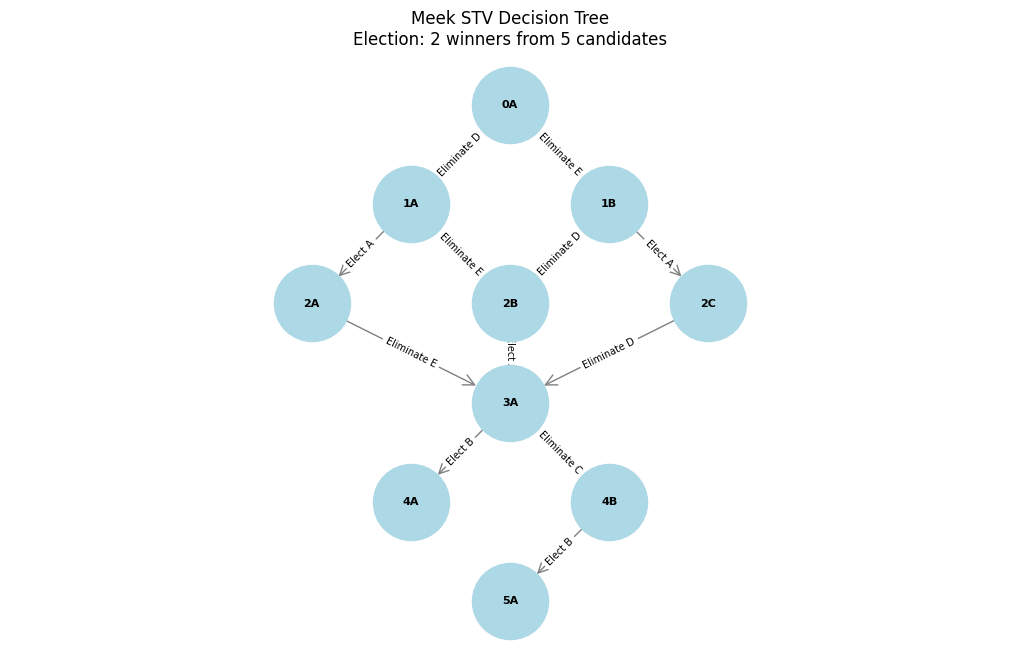

In [20]:
# Visualize the squeeze profile tree
test_graph2.plot_tree(figsize=(10, 6), label_nodes=True)

513.0
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[np.int64(0)] [1.]
[np.int64(0)] [0.8344041]
[np.int64(0), np.int64(20)] [0.80663474 0.8706486 ]


/home/nardo/research/contribute/3.3.0-MeekSTV/src/edouard/MeekGraph.py:398: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


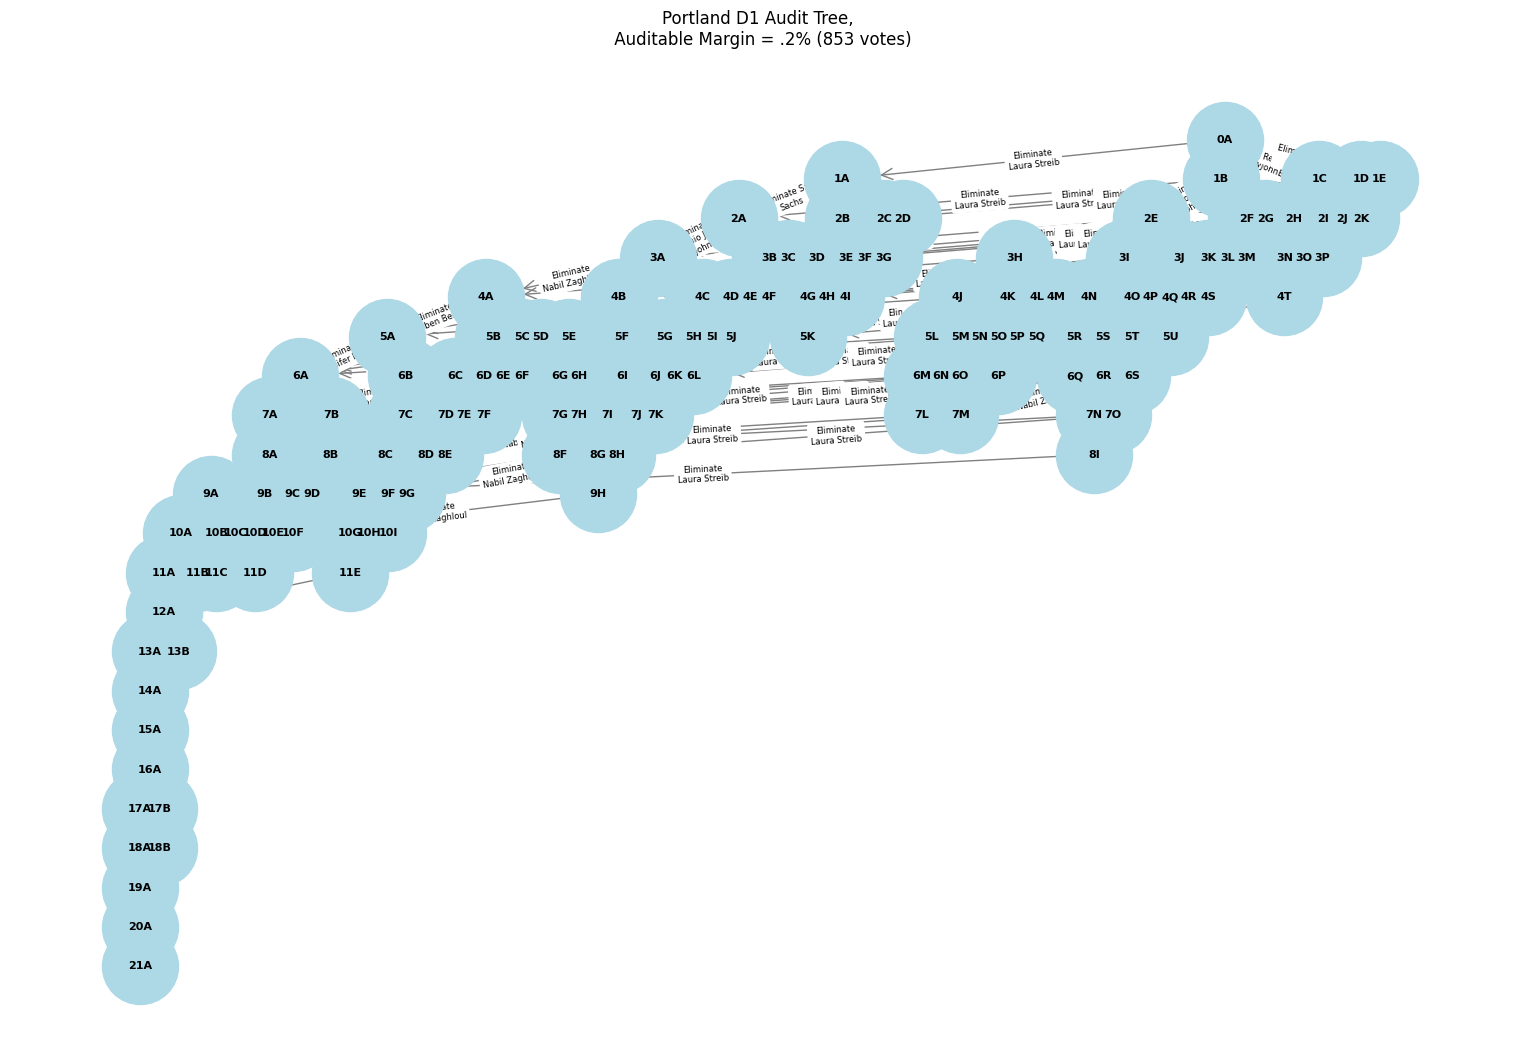

In [ ]:
from votekit.pref_profile import PreferenceProfile
from src.edouard.MeekGraph import MeekGraph

Portland_D1 = PreferenceProfile.from_pickle("data/portland/Portland_D1.pkl")

ballot_matrix, mult_vec, _ = convert_pf_to_numpy_arrays(new_profile)

N = sum(mult_vec)
print(N//150)

portland_graph = MeekGraph(profile=new_profile, m=3, auditable_margins_per_deg=[N//150, N//150, N//150], use_numerical_labels=False)
portland_graph.plot_graph(figsize=(8,12), node_size=500, label_nodes=True, title="Portland D1 Audit Tree, \n Auditable Margin = .2% (853 votes)", label_edges=True)

In [26]:
portland_graph.node_lookup["15B"]

{'node_str': 'W:3,4,8_L:1,2,5,6,7,9,10,11,12,13,14,15',
 'winner_to_cand': [np.int64(8), np.int64(4), np.int64(3)],
 'initial_losers': [np.int64(7),
  np.int64(9),
  np.int64(12),
  np.int64(1),
  np.int64(11),
  np.int64(15),
  np.int64(5),
  np.int64(10),
  np.int64(13),
  np.int64(2),
  np.int64(6),
  np.int64(14)],
 'layer': 15,
 'position_in_layer': 1}

In [11]:

N

np.float64(76566.0)

0
0.0
[] []
[np.int64(7)] [0.99986819]
[np.int64(7)] [0.99971005]
[np.int64(7)] [0.99918311]
[np.int64(7)] [0.99844618]
[np.int64(7)] [0.99810412]
[np.int64(7)] [0.99739381]
[np.int64(7)] [0.9960021]
[np.int64(7)] [0.99496675]
[np.int64(7)] [0.99331854]
[np.int64(7)] [0.99211638]
[np.int64(7)] [0.99033911]
[np.int64(7)] [0.9861868]
[np.int64(7)] [0.98359779]
[np.int64(7)] [0.97921622]
[np.int64(7)] [0.97388152]
[np.int64(7)] [0.96369217]
[np.int64(7)] [0.95143878]
[np.int64(7)] [0.93516313]
[np.int64(7)] [0.91991634]
[np.int64(7)] [0.90948249]
[np.int64(7)] [0.89664502]
[np.int64(7)] [0.87855092]
[np.int64(7)] [0.84146836]
[np.int64(7)] [0.79844597]
[np.int64(7)] [0.76069667]
[np.int64(7)] [0.70641878]
[np.int64(7)] [0.62025329]
[np.int64(7), np.int64(21)] [0.56552445 0.76841434]


/home/nardo/research/contribute/3.3.0-MeekSTV/src/edouard/MeekGraph.py:412: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


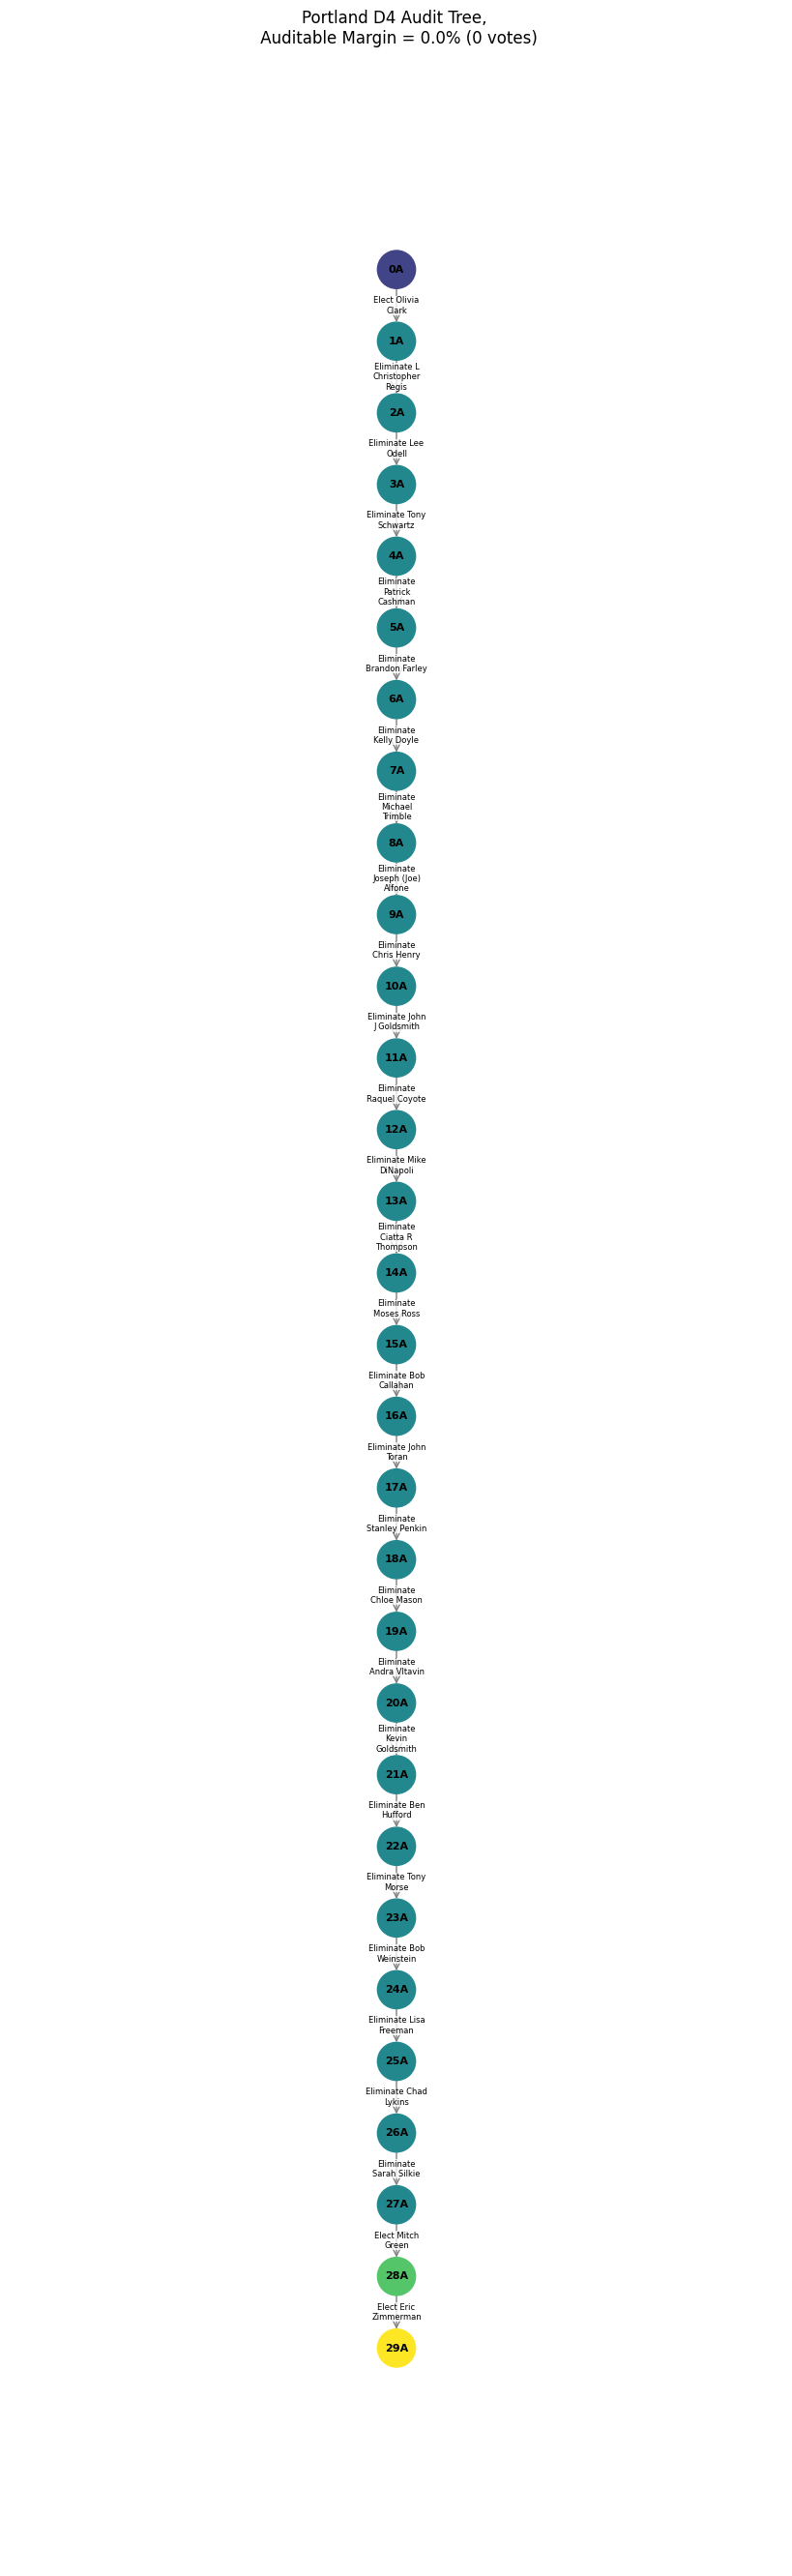

In [23]:
from votekit.pref_profile import PreferenceProfile
from votekit.cvr_loaders import load_csv, load_ranking_csv
from src.edouard.MeekGraph import MeekGraph
from src.edouard.utils import convert_pf_to_numpy_arrays

Portland_D2 = PreferenceProfile.from_pickle("data/portland/Portland_D4.pkl")

ballot_matrix, mult_vec, _ = convert_pf_to_numpy_arrays(Portland_D2)

N = sum(mult_vec)
frac = 0/N
percent = round(frac*100, 2)
num_vptes = int(N*frac)
print(num_vptes)
print(frac)

portland_graph = MeekGraph(profile=Portland_D2, m=3, auditable_margins_per_deg=[num_vptes, num_vptes, num_vptes], use_numerical_labels=False)
portland_graph.plot_graph(figsize=(8,26), node_size=800, label_nodes=True, title=f"Portland D4 Audit Tree, \n Auditable Margin = {percent}% ({num_vptes} votes)", label_edges=True, vertical_spacing=1000)

In [24]:
from votekit.cleaning import remove_repeat_cands_rank_profile, remove_and_condense_rank_profile

mama_this_is_garbaj = [key for key in Portland_D2.candidates if str(key).startswith("Write-in")]
mama_this_is_garbaj += [key for key in Portland_D2.candidates if str(key).startswith("Uncertified")]
mama_this_is_garbaj += [key for key in Portland_D2.candidates if str(key).startswith("rank")]
mama_this_is_garbaj += [key for key in Portland_D2.candidates if str(key).startswith("Rank")]
mama_this_is_garbaj += ["overvote", "undervote", "skipped"]

new_profile = remove_repeat_cands_rank_profile(Portland_D2)
new_profile = remove_and_condense_rank_profile(mama_this_is_garbaj, new_profile)
new_profile = new_profile.group_ballots()

new_profile

/home/nardo/research/contribute/3.3.0-MeekSTV/src/votekit/pref_profile/cleaned_pref_profile.py:159: UserWarning: Grouping the ballots of a CleanedRankProfile will return a RankProfile since this operation resets ballot indices.
  warnings.warn(


RankProfile
Maximum ranking length: 6
Candidates: ('Sameer Kanal', 'Laura Streib', 'Michael (Mike) Marshall', 'Jonathan Tasini', 'Nabil Zaghloul', 'Chris Olson', 'Mariah Hudson', 'Sam Sachs', 'Antonio Jamal PettyJohnBlue', 'Nat West', 'James Armstrong', 'Reuben Berlin', 'Jennifer Park', 'Bob Simril', 'Debbie Kitchin', 'Tiffani Penson', 'Michelle DePass', 'Dan Ryan', 'Will Mespelt', 'Liz Taylor', 'Elana Pirtle-Guiney', 'Marnie Glickman')
Candidates who received votes: ('Sameer Kanal', 'Reuben Berlin', 'Laura Streib', 'Michael (Mike) Marshall', 'Jonathan Tasini', 'Nabil Zaghloul', 'Chris Olson', 'Mariah Hudson', 'Jennifer Park', 'Sam Sachs', 'Antonio Jamal PettyJohnBlue', 'Bob Simril', 'Debbie Kitchin', 'Tiffani Penson', 'Michelle DePass', 'Dan Ryan', 'Will Mespelt', 'Liz Taylor', 'Nat West', 'Elana Pirtle-Guiney', 'James Armstrong', 'Marnie Glickman')
Total number of Ballot objects: 40952
Total weight of Ballot objects: 77024.0

In [6]:
import math

# ---------- core: hypergeometric zero-success tail ----------
def _prob_zero_given_M(N: int, n: int, M: int) -> float:
    """
    P(Y=0 | population has M 'success' ballots), SRSWOR.
    Uses a stable product: C(N-M, n) / C(N, n) = ∏_{t=0}^{n-1} (N-M-t)/(N-t)
    """
    if n == 0: return 1.0
    if M >= N - n + 1:  # too many successes to avoid at least 1 hit
        return 0.0
    p = 1.0
    for t in range(n):
        p *= (N - M - t) / (N - t)
    return max(0.0, min(1.0, p))

def hypergeo_zero_upper(N: int, n: int, alpha: float) -> int:
    """
    Max M such that P(Y=0 | M) >= alpha under SRSWOR.
    Monotone in M; return integer M_UB.
    """
    lo, hi = 0, N
    while lo < hi:
        mid = (lo + hi + 1) // 2
        if _prob_zero_given_M(N, n, mid) >= alpha:
            lo = mid
        else:
            hi = mid - 1
    return lo  # K_UB

# ---------- planning: sample size for a degree-0 margin ----------
def plan_n_for_deg0_margin(N: int, alpha: float, M_target: float) -> int:
    """
    Find the smallest n such that, if the sample is degenerate (all zeros),
    the worst-case contribution to the degree-0 margin |N*μ_ij| is ≤ M_target.

    For a margin X∈{-2,-1,0,1,2}, with zero observed, the hypergeo zero bound
    gives K_UB successes (|X|>0) in population, hence |N*μ_ij| ≤ 2*K_UB.
    We require 2*K_UB(N,n,alpha) ≤ M_target.

    Returns: n in [0, N]. If no n<N satisfies it, n==N will (full hand count).
    """
    # Quick checks
    if M_target <= 0:
        return N  # only full hand count collapses UB to 0
    # Binary search over n
    lo, hi = 0, N
    ans = N
    while lo <= hi:
        mid = (lo + hi) // 2
        K_UB = hypergeo_zero_upper(N, mid, alpha)
        if 2 * K_UB <= M_target:
            ans = mid
            hi = mid - 1
        else:
            lo = mid + 1
    return ans

# ---------- reverse: variance upper bounds for degenerate samples ----------
def degenerate_variance_upper(N: int, n: int, alpha: float, kind: str = "margin"):
    """
    Given N, n, alpha and a degenerate sample (all zeros), return:
      - vX_UB: per-ballot variance upper bound Var(X)
      - vmean_UB: variance upper bound of the sample MEAN Var( X̄ )

    kind:
      "candidate" -> X ∈ {-1,0,1}:  Var(X) ≤ q_UB, where q_UB = K_UB / N
      "margin"    -> X ∈ {-2..2}  :  Var(X) ≤ 4 q_UB  (worst-case |X|=2)

    Design variance for the MEAN under SRSWOR:
      Var(X̄) = (1 - n/N) * Var(X) / n
    """
    K_UB = hypergeo_zero_upper(N, n, alpha)           # # of nonzeros UB
    q_UB = K_UB / N                                   # rate UB
    if kind == "candidate":
        vX_UB = q_UB
    elif kind == "margin":
        vX_UB = 4.0 * q_UB
    else:
        raise ValueError("kind must be 'candidate' or 'margin'")
    fpc = max(0.0, 1.0 - n / N)
    vmean_UB = fpc * vX_UB / max(1, n)
    return vX_UB, vmean_UB


In [22]:
N=76500

N**2*degenerate_variance_upper(int(N), int(N)//5, 0.05, kind="candidate")[1]

52.00000000000001

In [7]:
N

np.float64(76566.0)